[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis/W2D3_Tutorial4.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis/W2D3_Tutorial4.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 4: Public Opinion on the Climate Emergency and Why it Matters**

**Week 2, Day 3: IPCC Socio-economic Basis**

**Content creators:** Maximilian Puelma Touzel

**Content reviewers:** Peter Ohue, Derick Temfack, Zahra Khodakaramimaghsoud, Peizhen Yang, Younkap Nina Duplex, Laura Paccini, Sloane Garelick, Abigail Bodner, Manisha Sinha, Agustina Pesce, Dionessa Biton, Cheng Zhang, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorial Objectives** 
In this tutorial, we will explore a dataset derived from Twitter, focusing on public sentiment surrounding the [Conference of Parties (COP) climate change conferences](https://unfccc.int/process/bodies/supreme-bodies/conference-of-the-parties-cop). We will use data from a published study by [Falkenberg et al. *Nature Clim. Chg.* 2022](https://www.nature.com/articles/s41558-022-01527-x). This dataset encompasses tweets mentioning the COP conferences, which bring together world governments, NGOs, and businesses to discuss and negotiate on climate change progress. Our main objective is to understand public sentiment about climate change and how it has evolved over time through an analysis of changing word usage on social media. In the process, we will also learn how to manage and analyze large quantities of text data.

The tutorial is divided into sections, where we first delve into loading and inspecting the data, examining the timing and languages of the tweets, and analyzing sentiments associated with specific words, including those indicating 'hypocrisy'. We'll also look at sentiments regarding institutions within these tweets and compare the sentiment of tweets containing 'hypocrisy'-related words versus those without. This analysis is supplemented with visualization techniques like word clouds and distribution plots.

By the end of this tutorial, you will have developed a nuanced understanding of how text analysis can be used to study public sentiment on climate change and other environmental issues, helping us to navigate the intricate and evolving landscape of climate communication and advocacy.


# **Setup**

In [4]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#notebook config
from IPython.display import display, HTML
import datetime
import re
import nltk
from nltk.corpus import stopwords
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import urllib.request  # the lib that handles the url stuff
from afinn import Afinn
import pooch
import os
import tempfile

In [5]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

sns.set_style("ticks", {'axes.grid' : False})
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# @title Video 2: A Simple Greenhouse Model
#Tech team will add code to format and display the video

In [7]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1: Data Preprocessing**

We have performed the following preprocessing steps for you (simply follow along; there is no need to execute any commands in this section):

Every Twitter message (hereon called *tweets*) has an ID. IDs of all tweets mentioning `COPx` (x=20-26, which refers to the session number of each COP meeting) used in [Falkenberg et al. (2022)](https://doi.org/10.1038/s41558-022-01527-x) were placed by the authors in an [osf archive](https://osf.io/nu75j). You can download the 7 .csv files (one for each COP) [here](https://osf.io/download/pr29x/) 

The `twarc2` program serves as an interface with the Twitter API, allowing users to retrieve full tweet content and metadata by providing the tweet ID. Similar to GitHub, you need to create a Twitter API account and configure `twarc` on your local machine by providing your account authentication keys. To rehydrate a set of tweets using their IDs, you can use the following command: `twarc2 hydrate source_file.txt store_file.jsonl`. In this command, each line of the `source_file.txt` represents a Twitter ID, and the hydrated tweets will be stored in the `store_file.jsonl`.


- First, format the downloaded IDs and split them into separate files (*batches*) to make hydration calls to the API more time manageable (hours versus days - this is slow because of an API-imposed limit of 100 tweets/min.). 

In [8]:
# import os
# dir_name='Falkenberg2022_data/'
# if not os.path.exists(dir_name):
#     os.mkdir(dir_name)
# batch_size = int(1e5)
# download_pathname=''#~/projects/ClimateMatch/SocioEconDay/Polarization/COP_Twitter_IDs/
# for copid in range(20,27):
#     df_tweetids=pd.read_csv(download_pathname+'tweet_ids_cop'+str(copid)+'.csv')
#     for batch_id,break_id in enumerate(range(0,len(df_tweetids),batch_size)):
#         file_name="tweetids_COP"+str(copid)+"_b"+str(batch_id)+".txt"
#         df_tweetids.loc[break_id:break_id+batch_size,'id'].to_csv(dir_name+file_name,index=False,header=False)

- Make the hydration calls for COP26 (this took 4 days to download 50GB of data for COP26).

In [9]:
# import glob
# import time
# copid=26
# filename_list = glob.glob('Falkenberg2022_data/'+"tweetids_COP"+str(copid)+"*")
# dir_name='tweet_data/'
# if not os.path.exists(dir_name):
#     os.mkdir(dir_name)
# file_name="tweetids_COP"+str(copid)+"_b"+str(batch_id)+".txt"
# for itt,tweet_id_batch_filename in enumerate(filename_list):
#     strvars=tweet_id_batch_filename.split('/')[1].split('.')[0].split('_')
#     tweet_store_filename = dir_name+'tweets_'+strvars[1]+'_'+strvars[2]+'.json'
#     if not os.path.exists(tweet_store_filename):
#         st=time.time()
#         os.system('twarc2 hydrate '+tweet_id_batch_filename+' '+tweet_store_filename)
#         print(str(itt)+' '+str(strvars[2])+" "+str(time.time()-st))

- Load the data, then inspect and pick a chunk size. Note, by default, there are 100 tweets per line in the `.json` files returned by the API. Given we asked for 1e5 tweets/batch, there should be 1e3 lines in these files.

In [10]:
# copid=26
# batch_id = 0
# tweet_store_filename = 'tweet_data/tweets_COP'+str(copid)+'_b'+str(batch_id)+'.json'
# num_lines = sum(1 for line in open(tweet_store_filename))
# num_lines

- Now we read in the data, iterating over chunks in each batch and only store the needed data in a dataframe (takes 10-20 minutes to run). Let's look at when the tweets were posted, what language they are in, and the tweet text:

In [11]:
# selected_columns = ['created_at','lang','text']

In [12]:
# st=time.time()
# filename_list = glob.glob('tweet_data/'+"tweets_COP"+str(copid)+"*")
# df=[]
# for tweet_batch_filename in filename_list[:-1]:
#     reader = pd.read_json(tweet_batch_filename, lines=True,chunksize=1)
# #     df.append(pd.DataFrame([item[selected_columns] for sublist in reader.data.values.tolist()[:-1] for item in sublist] )[selected_columns])
#     dfs=[]
#     for chunk in reader:
#         if 'data' in chunk.columns:
#             dfs.append(pd.DataFrame(list(chunk.data.values)[0])[selected_columns])
#     df.append(pd.concat(dfs,ignore_index=True))
# #     df.append(pd.DataFrame(list(reader.data)[0])[selected_columns])
# df=pd.concat(df,ignore_index=True)
# df.created_at=pd.to_datetime(df.created_at)
# print(str(len(df))+' tweets took '+str(time.time()-st))
# df.head()

- Finally, store the data in the efficiently compressed feather format

In [13]:
# df.to_feather('stored_tweets')

# **Section 2: Load and Inspect Data**

Now that we have reviewed the steps that were taken to generate the preprocessed data, we can load the data. It may a few minutes to download the data.

In [16]:
filename_tweets='stored_tweets'
url_tweets='https://osf.io/download/8p52x/'
df=pd.read_feather(pooch_load(url_tweets,filename_tweets)) #takes a couple minutes to download

Let's check the timing of the tweets relative to the COP26 event (duration shaded in blue in the plot you will make) to see how the number of tweets vary over time.

/tmp/ipykernel_7070/2932246276.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


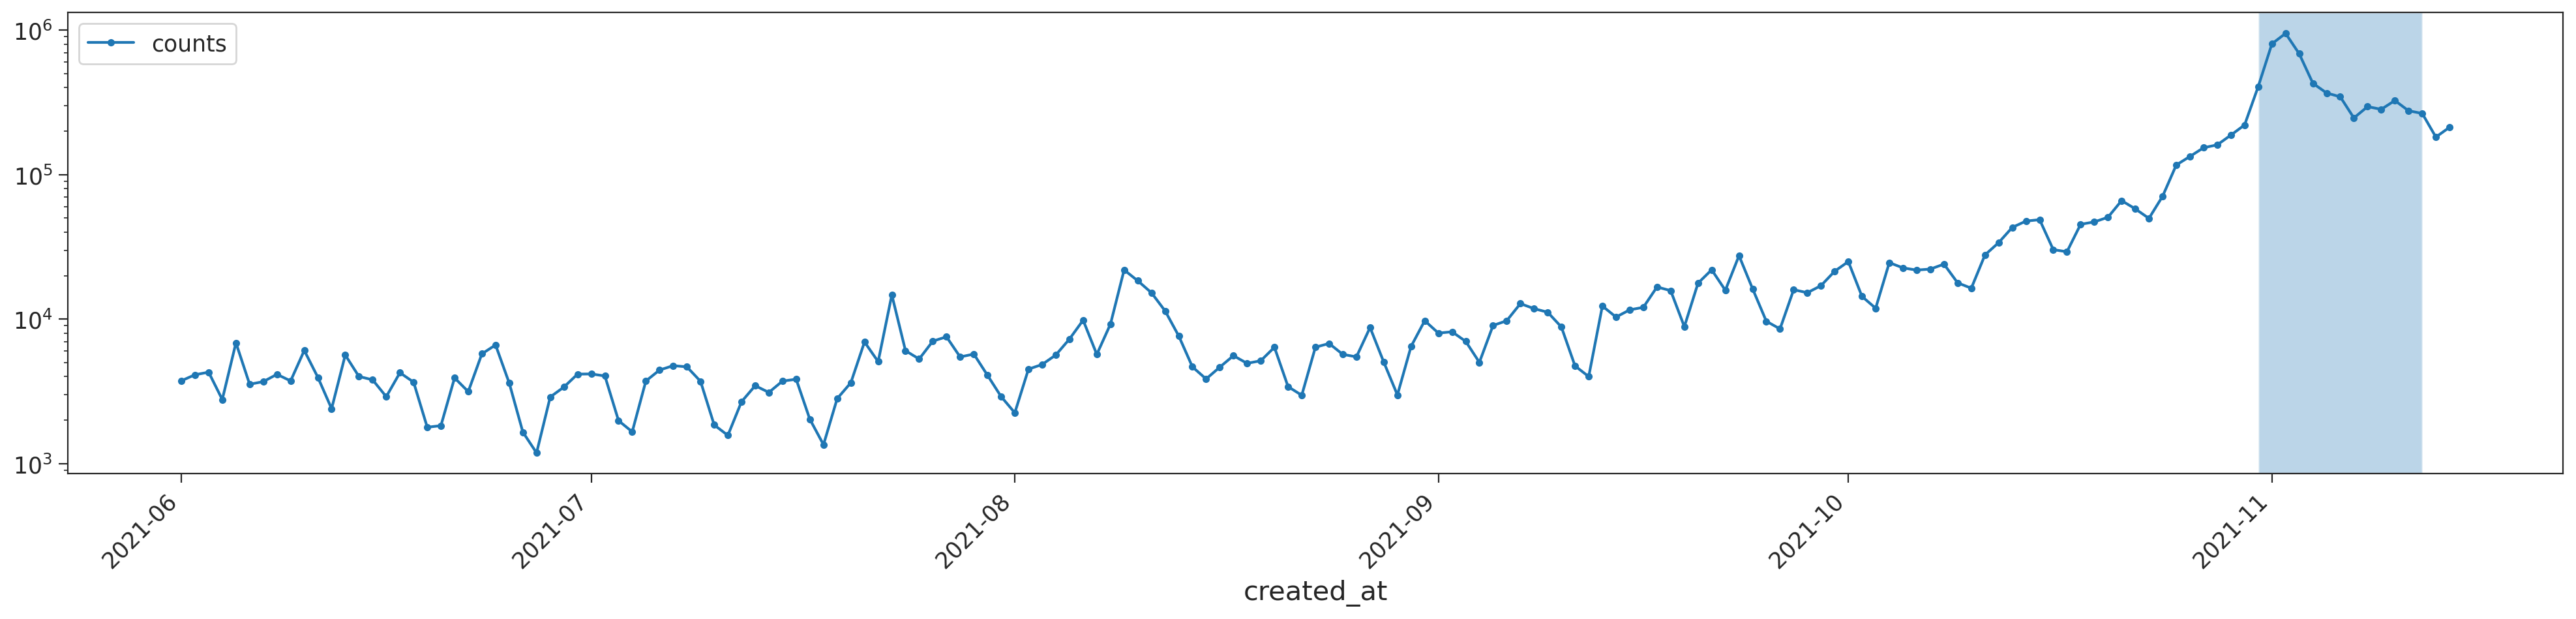

In [22]:
total_tweetCounts=df.created_at.groupby(df.created_at.apply(lambda x: x.date)).count().rename('counts')
fig,ax=plt.subplots()
total_tweetCounts.reset_index().plot(x='created_at',y='counts',figsize=(20,5),style='.-',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_yscale('log')
COPdates=[datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)] #shade the duration of the COP26 to guide the eye
ax.axvspan(*COPdates, alpha=0.3); #gray region

In addition to assessing the number of tweets, we can also explore who was tweeting about this COP. Look at how many tweets were posted in various languages:

In [23]:
counts=df.lang.value_counts().reset_index()

The language name of the tweet is stored as a code name. We can pull a language code dictionary from the web and use it to translate the language code to the language name.

In [24]:
target_url='https://gist.githubusercontent.com/carlopires/1262033/raw/c52ef0f7ce4f58108619508308372edd8d0bd518/gistfile1.txt'
exec(urllib.request.urlopen(target_url).read())
lang_code_dict=dict(iso_639_choices)
counts=counts.replace({'index':lang_code_dict})
counts

,lang,count
0,en,6570754
1,es,742064
2,fr,321012
3,ja,229586
4,pt,165717
...,...,...
66,ps,23
67,ka,22
68,bo,16
69,sd,7


### **Coding Exercise 2**
Run the following cell to print the dictionary for the language codes:

In [25]:
lang_code_dict

{'ab': 'Abkhaz',
 'aa': 'Afar',
 'af': 'Afrikaans',
 'ak': 'Akan',
 'sq': 'Albanian',
 'am': 'Amharic',
 'ar': 'Arabic',
 'an': 'Aragonese',
 'hy': 'Armenian',
 'as': 'Assamese',
 'av': 'Avaric',
 'ae': 'Avestan',
 'ay': 'Aymara',
 'az': 'Azerbaijani',
 'bm': 'Bambara',
 'ba': 'Bashkir',
 'eu': 'Basque',
 'be': 'Belarusian',
 'bn': 'Bengali',
 'bh': 'Bihari',
 'bi': 'Bislama',
 'bs': 'Bosnian',
 'br': 'Breton',
 'bg': 'Bulgarian',
 'my': 'Burmese',
 'ca': 'Catalan; Valencian',
 'ch': 'Chamorro',
 'ce': 'Chechen',
 'ny': 'Chichewa; Chewa; Nyanja',
 'zh': 'Chinese',
 'cv': 'Chuvash',
 'kw': 'Cornish',
 'co': 'Corsican',
 'cr': 'Cree',
 'hr': 'Croatian',
 'cs': 'Czech',
 'da': 'Danish',
 'dv': 'Divehi; Maldivian;',
 'nl': 'Dutch',
 'dz': 'Dzongkha',
 'en': 'English',
 'eo': 'Esperanto',
 'et': 'Estonian',
 'ee': 'Ewe',
 'fo': 'Faroese',
 'fj': 'Fijian',
 'fi': 'Finnish',
 'fr': 'French',
 'ff': 'Fula',
 'gl': 'Galician',
 'ka': 'Georgian',
 'de': 'German',
 'el': 'Greek, Modern',
 'gn': '

Find your native language code in the dictionary you just printed and use it to select the COP tweets that were written in your language! 

In [ ]:
language_code = ...
df=df.loc[df.lang==language_code,:].reset_index(drop=True)
pd.options.display.max_rows=100 #see up to 100 entries
pd.options.display.max_colwidth=250 #widen how much text is presented of each tweet
df.sample(100)

In [26]:
# to_remove solution

language_code = 'en'
df=df.loc[df.lang==language_code,:].reset_index(drop=True)
pd.options.display.max_rows=100 #see up to 100 entries
pd.options.display.max_colwidth=250 #widen how much text is presented of each tweet
df.sample(100)

,created_at,lang,text
5043079,2021-11-07 00:43:39+00:00,en,RT @MichaelAMacNeil: Waiting in an reassuringly wet Glasgow for the #ClimateJustice march to leave #COP26Glasgow #COP26 https://t.co/nFunD2…
3016726,2021-11-02 06:25:55+00:00,en,"RT @DrEmmaLJohnston: I'm going to be joining the @ABCthedrum panel this evening to talk about CLIMATE, COAL, COVID, &amp; NUCLEAR SUBS! Join us…"
4427655,2021-11-04 20:28:01+00:00,en,"RT @LaurencePessez: I was especially inspired by @raviabeywardana words, from @CDSBglobal: because environmental risks are financial risks,…"
246524,2021-11-14 07:54:18+00:00,en,@reginalddhunter See it’s all good until COP26 doesn’t do anything and then .. https://t.co/hkaJY9vcjy
4329031,2021-11-04 13:35:48+00:00,en,RT @JunkScience: Banning the financing of coal plants in poor countries is pure evil.\n\n#COP26 president @AlokSharma_RDG is aiding and abett…
1009387,2021-10-24 20:34:54+00:00,en,RT @arikring: @Hazloe3 @ProfStrachan @ECOWARRIORSS @MsFowlersays @ChristineMilne @ristori20 @mzjacobson @charluv2011 @BSuhic @NJdoc @ddelic…
5302834,2021-11-08 07:33:29+00:00,en,RT @antonioguterres: Climate-driven famine is already a reality for families in southern Madagascar.\n\nAs #COP26 discussions enter their sec…
4640108,2021-11-05 12:21:32+00:00,en,RT @MertonTV: The Council will install up to 68 @Breathe_London sensors by the end of the month providing Live coverage for nitrogen dioxid…
250653,2021-11-14 08:17:56+00:00,en,I love how no one really took climate change seriously during #COP26 and by no one I meant the US.
5988067,2021-11-10 21:17:34+00:00,en,RT @RMTunion: Rail union RMT has called on Scotland's political leadership to take responsibility &amp; intervene as strike action on @CalSleep…


# **Section 3: Word Set Prevalence**

[Falkenberg et al.](https://www.nature.com/articles/s41558-022-01533-z) investigated the hypothesis that *public sentiment* around the COP conferences has increasingly framed them as hypocritical ("political hypocrisy as a topic of cross-ideological appeal"). The authors operationalized hypocrisy language as any tweet containing any of the following words:

In [27]:
selected_words = ['hypocrisy', 'hypocrite', 'hypocritical', 'greenwash','green wash', 'blah'] #the last 3 words don't add much. Greta Thurnberg's 'blah, blah blah' speech on Sept. 28th 2021.

## **Questions 3**


1. How might this matching procedure be limited in its ability to capture this sentiment?

In [ ]:
# to_remove explanation

"""
1. Our approach is based on a predetermined dictionary, which might have several limitations in accurately capturing sentiment. Contextual ignorance (e.g., the word "not" can reverse the sentiment of the following word, but this isn't captured in a simple matching procedure) and language and cultural differences cannot be well captured.
"""''

The authors then searched for these words within a distinct dataset across all COP conferences (this dataset was not made openly accessible but the figure using that data is [here](https://www.nature.com/articles/s41558-022-01527-x/figures/7)). They found that hypocrisy has been mentioned more in recent COP conferences.

Here, we will shift our focus to their accessible COP26 dataset and analyze the nature of comments related to specific topics, such as political hypocrisy. First, let's look through the whole dataset and pull tweets that mention any of the selected words.

In [28]:
selectwords_detector = re.compile(r'\b(?:{0})\b'.format('|'.join(selected_words))) #to make a word detector for a wordlist faster to run, compile it!
df['select_talk']=df.text.apply(lambda x: selectwords_detector.search(x,re.IGNORECASE)) # look through whole dataset, flagging tweets with select_talk (computes in under a minute)

Let's extract these tweets and examine their occurrence statistics in relation to the entire dataset that we calculated above.

In [29]:
selected_tweets=df.loc[~df.select_talk.isnull(),:]
selected_tweet_counts=selected_tweets.created_at.groupby(selected_tweets.created_at.apply(lambda x: x.date)).count().rename('counts')
selected_tweet_fraction=selected_tweet_counts/total_tweetCounts

/tmp/ipykernel_7070/848961848.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


Text(0, 0.5, 'fraction talking about hypocrisy')

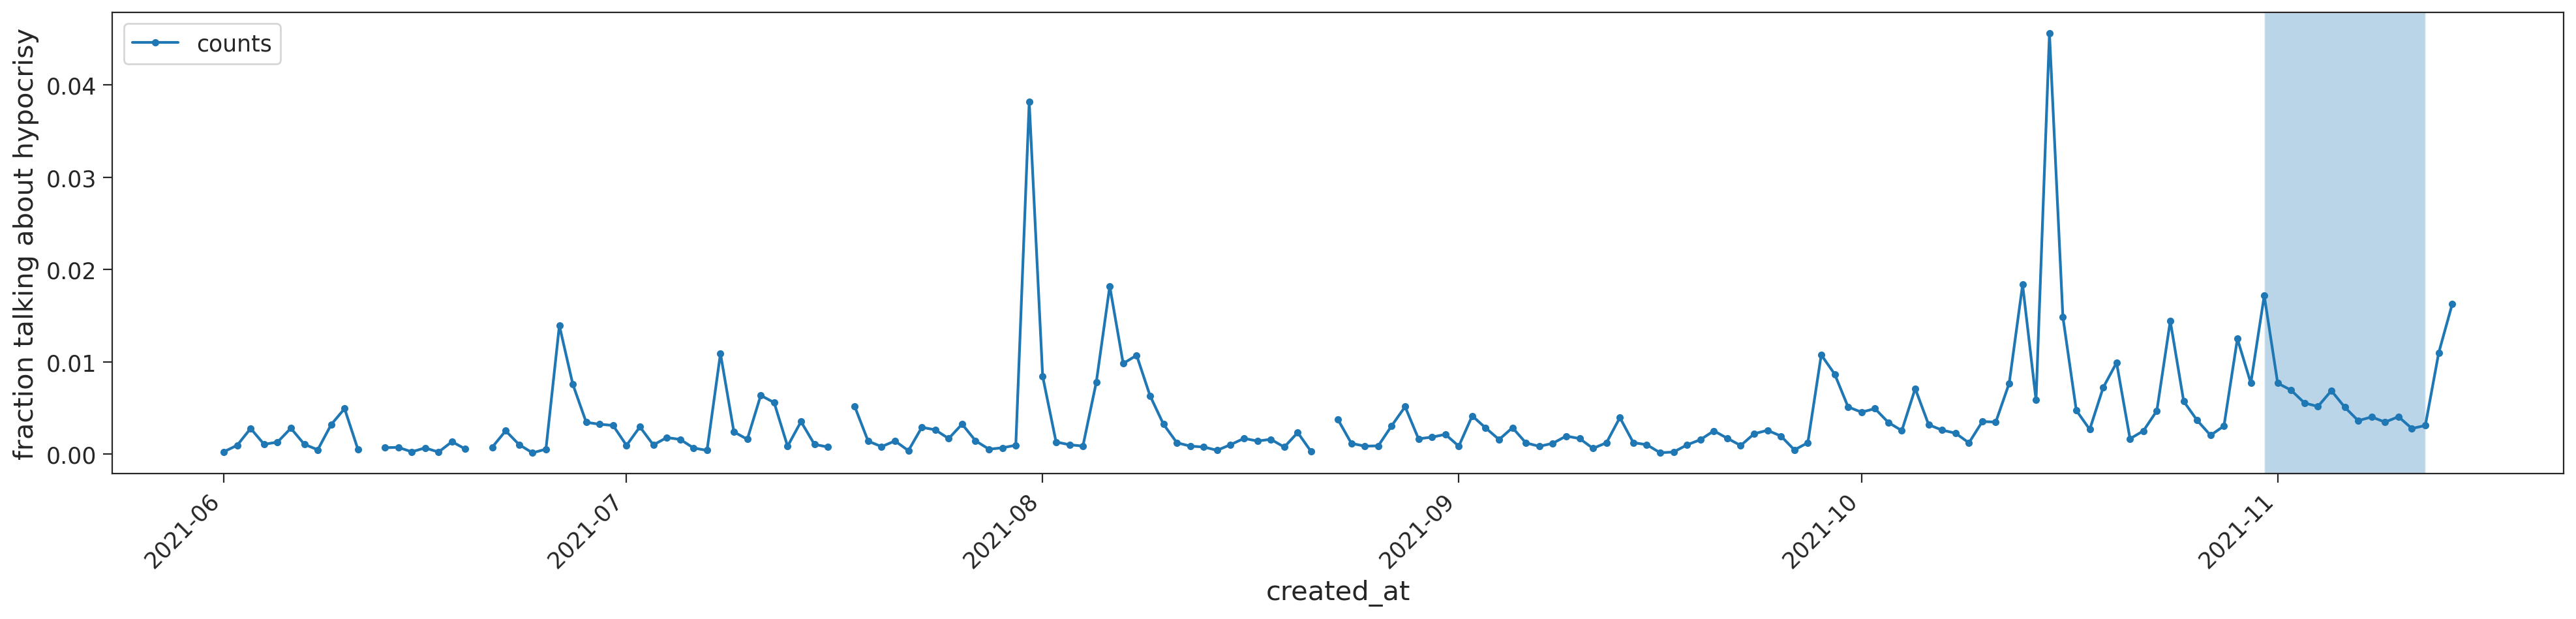

In [31]:
fig,ax=plt.subplots(figsize=(20,5))
selected_tweet_fraction.reset_index().plot(x='created_at',y='counts',style=['.-'],ax=ax) 
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.axvspan(*COPdates, alpha=0.3) #gray region
ax.set_ylabel('fraction talking about hypocrisy')

Please note that these fractions are normalized, meaning that larger fractions closer to the COP26 dates (shaded in blue) when the total number of tweets are orders of magnitude larger indicate a significantly greater absolute number of tweets talking about hypocrisy.

Now, let's examine the content of these tweets by randomly sampling 100 of them.

In [32]:
selected_tweets.text.sample(100).values

array(['@BorisJohnson @COP26 This is #LiarJohnson, so we’re used to bullshit from him.\nBut he’s taken muckspreading to a new level now that he &amp; his gang are dumping actual human excrement around the country.\n\nWith that &amp; their fossil fuels hypocrisy, the Johnson regime can claim no green high ground at all.',
       '@annietrev @COP26 More word confetti from my lying hypocritical MP!\n\nhttps://t.co/gXtUjrajU8 https://t.co/r4gAgPqkm7',
       'RT @brothadestin: Like @GretaThunberg said we ain’t gat no time for blah blah blah it’s time to #ActNow as we heading to the @COP26 #COP26…',
       'Enough of the blah blah blah— we call for outcomes and Action from #COP26. https://t.co/1f1zL97e5O',
       'RT @davidkurten: COP26 is a load of hypocritical garbage. The 30,000 climate alarmists flying in on their private jets and staying in luxur…',
       'RT @BernieSpofforth: "There are three things in the world that deserve no mercy: hypocrisy, fraud, and tyranny" \n— Frederick W. R

## **Coding Exercise 3**


1. Please select another topic and provide a list of topic words. We will then conduct the same analysis for that topic. For example, if the topic is "renewable technology," please provide a list of relevant words.

In [33]:
selected_words_2 = ...

selectwords_detector_2 = re.compile(r'\b(?:{0})\b'.format('|'.join(selected_words_2)))
df['select_talk_2']=df.text.apply(lambda x: selectwords_detector_2.search(x,re.IGNORECASE))

selected_tweets_2=df.loc[~df.select_talk_2.isnull(),:]
selected_tweet_counts_2=selected_tweets_2.created_at.groupby(selected_tweets_2.created_at.apply(lambda x: x.date)).count().rename('counts')
selected_tweet_fraction_2=selected_tweet_counts_2/total_tweetCounts

selected_tweets_2.text.sample(100).values

KeyboardInterrupt: 

In [34]:
# to_remove solution

selected_words_2 = ['renewable','wind', 'solar', 'geothermal', 'biofuel']

selectwords_detector_2 = re.compile(r'\b(?:{0})\b'.format('|'.join(selected_words_2)))
df['select_talk_2']=df.text.apply(lambda x: selectwords_detector_2.search(x,re.IGNORECASE))

selected_tweets_2=df.loc[~df.select_talk_2.isnull(),:]
selected_tweet_counts_2=selected_tweets_2.created_at.groupby(selected_tweets_2.created_at.apply(lambda x: x.date)).count().rename('counts')
selected_tweet_fraction_2=selected_tweet_counts_2/total_tweetCounts

selected_tweets_2.text.sample(100).values

array(["RT @KawsachunNews: Bolivia's President Luis Arce inaugurated a wind farm today in Santa Cruz, two days after returning from COP26.\n\nThis is…",
       'RT @Char_FentonUK: #CountdowntoCOP26 1️⃣0️⃣days to go. You may have heard of renewable energy - but what does it mean? Why is energy so imp…',
       'RT @fraserjfstewart: What. A. Day. 100,000 people from all over in the streets of Glasgow, in the rain and wind and sun, demanding climate…',
       "RT @BomenAchterhoek: .@DraxGroup's burning of #BigBadBiomass in the name of renewable energy is a #BiomassDelusion. Tell #COP26 to stop all…",
       'RT @AaronBastani: In a number of areas, from high speed rail to reforestation and renewable energy, China is a global leader in tackling cl…',
       'RT @CityAM: For wind energy to be truly sustainable it needs to be circular and re-use retired turbines \n\nA circular economy must be at the…',
       'RT @ProfMarkMaslin: Governments must do #COP26 list\n\n🪨 Ban coal worldwide\n⛽️ Rem

# **Section 4: Sentiment Analysis**

Let's test this hypothesis from [Falkenberg et al.](https://www.nature.com/articles/s41558-022-01533-z) (that *public sentiment* around the COP conferences has increasingly framed them as political hypocrisy). To do so, we can use **sentiment analysis**, which is a method for computing the proportion of words that have positive connotations, negative connotations or are neutral. Some sentiment analysis systems can measure other word attributes as well. In this case, we will analyze the sentiment of the subset of tweets that mention international organizations central to globalization (e.g., G7), focusing specifically on the tweets related to hypocrisy.

Note: part of the computation flow in what follows is from [Caren Neal's tutorial](https://nealcaren.org/lessons/wordlists/).

We'll assign tweets a sentiment score using a dictionary method (i.e. based on the word sentiment scores of words in the tweet that appear in given word-sentiment score dictionary). The particular word-sentiment score dictionary we will use is compiled in the [AFINN package](https://pypi.org/project/afinn/) and reflects a scoring between -5 (negative connotation) and 5 (positive connotation). The English language dictionary consists of 2,477 coded words.

Let's initialize the dictionary for the selected language. For example, the language code for English is 'en'.

In [35]:
afinn = Afinn(language=language_code)

Now we can load the dictionary:

In [36]:
filename_afinn_wl='AFINN-111.txt'
url_afinn_wl = 'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-111.txt'

afinn_wl_df = pd.read_csv(pooch_load(url_afinn_wl,filename_afinn_wl),
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value']) #new column names
seed = 808 # seed for sample so results are stable
afinn_wl_df.sample(10, random_state = seed)

SHA256 hash of downloaded file: 4703e14ed5ce7cb73591037cf21a202c0bdf8bdac06392808a1d5606ecf77a06
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


,term,value
1852,regret,-2
1285,indifferent,-2
681,disappoints,-2
770,doubts,-1
1644,outmaneuvered,-2
55,admit,-1
1133,haha,3
1160,haunt,-1
2435,wishing,1
21,abused,-3


Let's look at the distribution of scores over all words in the dictionary

Text(0, 0.5, 'dictionary counts')

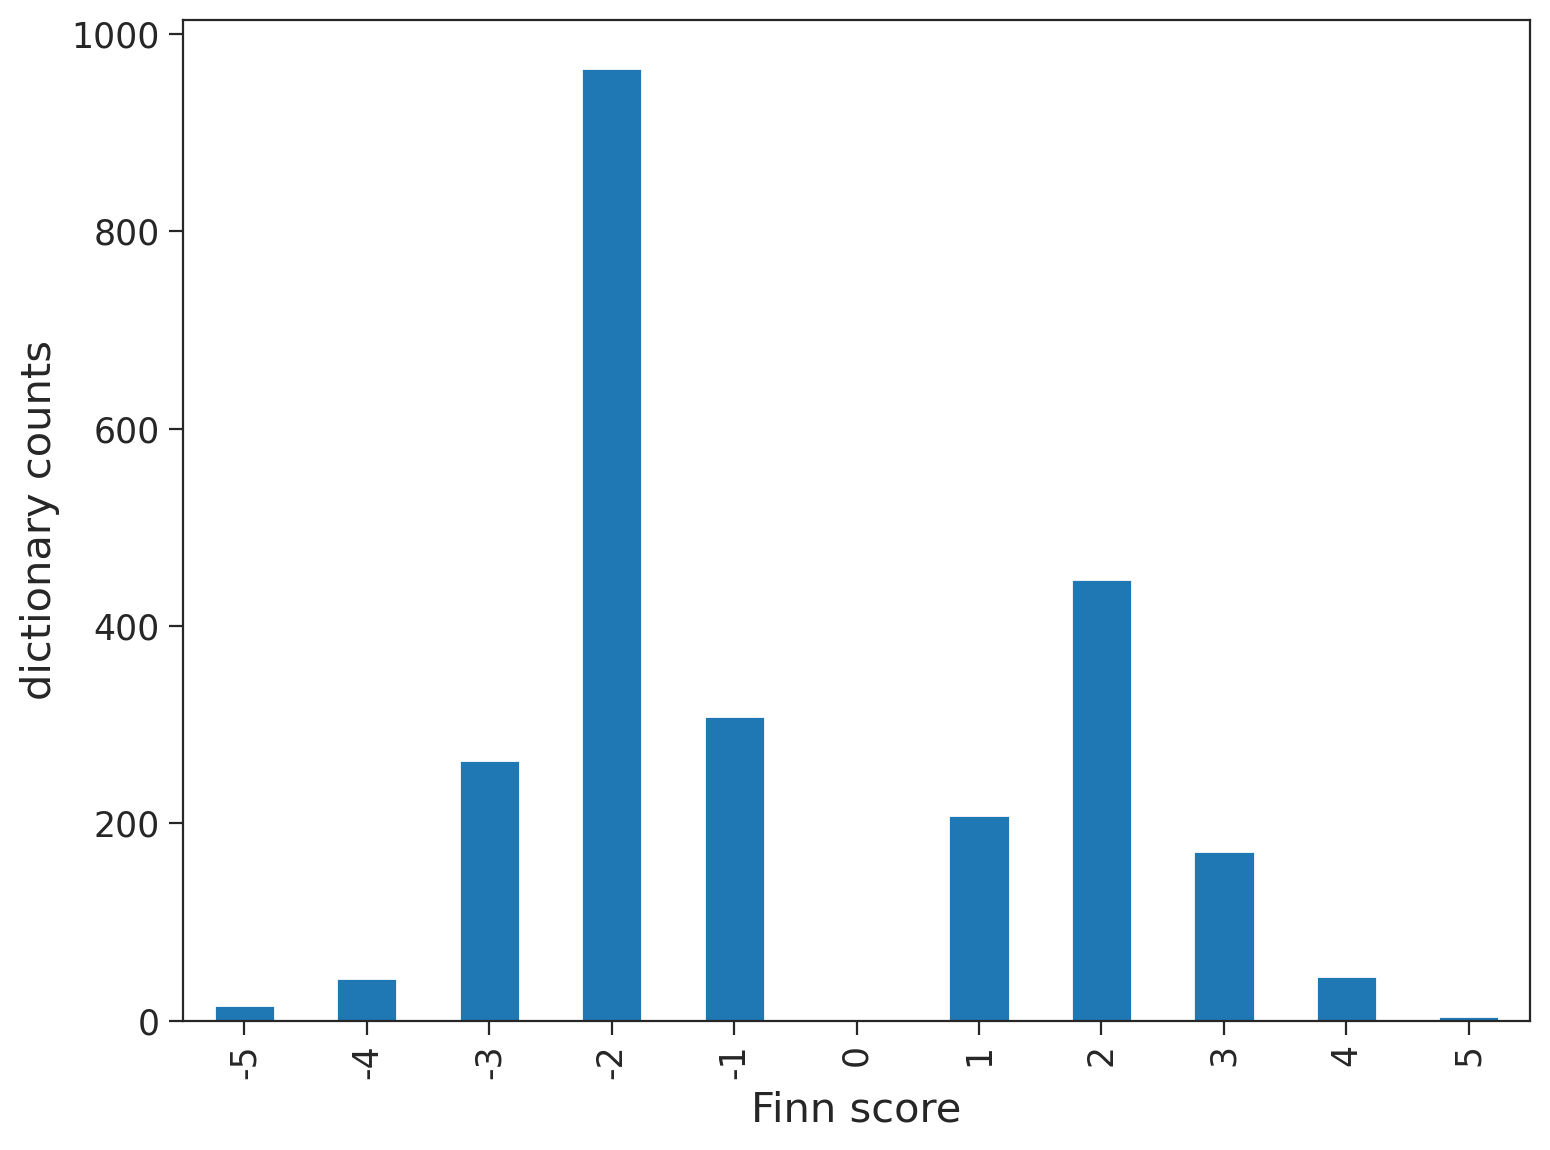

In [38]:
fig,ax=plt.subplots()
afinn_wl_df.value.value_counts().sort_index().plot.bar(ax=ax)
ax.set_xlabel('Finn score')
ax.set_ylabel('dictionary counts')

These scores were assigned to words based on labeled tweets ([validation paper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf)).  

Before focussing on sentiments about institutions within the hypocrisy tweets, let's look at the hypocrisy tweets in comparison to non-hypocrisy tweets. This will take some more intensive computation, so let's only perform it on a 1% subsample of the dataset

In [39]:
smalldf=df.sample(frac=0.01)

In [40]:
smalldf['afinn_score'] = smalldf.text.apply(afinn.score) #intensive computation! We have reduced the data set to frac=0.01 it's size so it takes ~1 min. (the full dataset takes 1hrs 50 min.)

In [41]:
smalldf['afinn_score'].describe() # generate descriptive statistics.

count    65708.000000
mean         0.408702
std          2.749613
min        -29.000000
25%         -1.000000
50%          0.000000
75%          2.000000
max         24.000000
Name: afinn_score, dtype: float64

From this, we can see that the maximum score is 24 and the minimum score is -33. The score is computed by summing up the scores of all dictionary words present in the tweet, which means that longer tweets tend to have higher scores.

To make the scores comparable across tweets of different lengths, a rough approach is to convert them to a per-word score. This is done by normalizing each tweet's score by its word count. It's important to note that this per-word score is not specific to the dictionary words used, so this approach introduces a bias that depends on the proportion of dictionary words in each tweet. We will refer to this normalized score as *afinn_adjusted*.

In [42]:
def word_count(text_string):
    '''Calculate the number of words in a string'''
    return len(text_string.split())
smalldf['word_count']=smalldf.text.apply(word_count)
smalldf['afinn_adjusted'] = smalldf['afinn_score'] / smalldf['word_count'] #note this isn't a percentage

In [43]:
smalldf['afinn_adjusted'].describe()

count    65708.000000
mean         0.017949
std          0.128394
min         -2.000000
25%         -0.040000
50%          0.000000
75%          0.086957
max          1.666667
Name: afinn_adjusted, dtype: float64

After normalizing the scores, we find that the maximum score is now 2 and the minimum score is now -1.5. 

Now let's look at the sentiment of tweets with hypocrisy words versus those without those words. For reference, we'll first make cumulative distribution plots of score distributions for some other possibly negative words: fossil, G7, Boris and Davos.

In [44]:
for sel_words in [['Fossil'],['G7'],['Boris'],['Davos'],selected_words]:
    sel_name = sel_words[0] if len(sel_words)==1 else 'select_talk'
    selectwords_detector = re.compile(r'\b(?:{0})\b'.format('|'.join(sel_words))) #compile for speed!
    smalldf[sel_name] = smalldf.text.apply(lambda x: selectwords_detector.search(x,re.IGNORECASE) is not None) #flag if tweet has word(s)

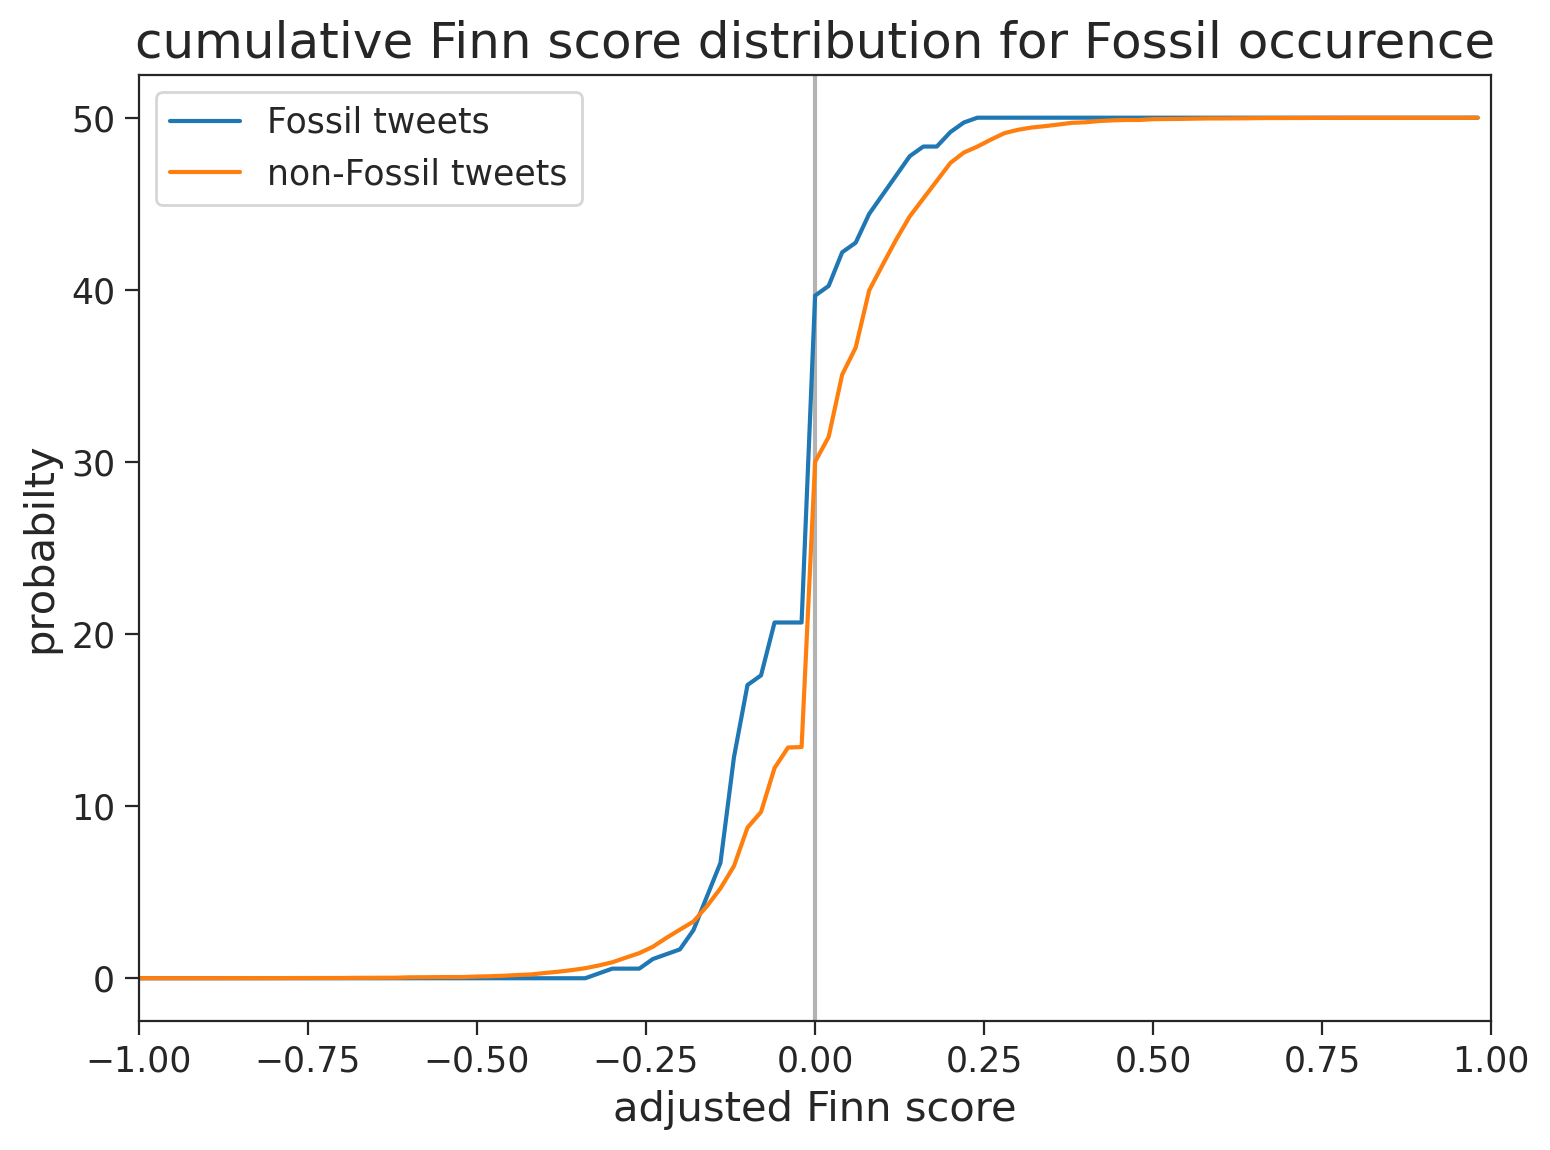

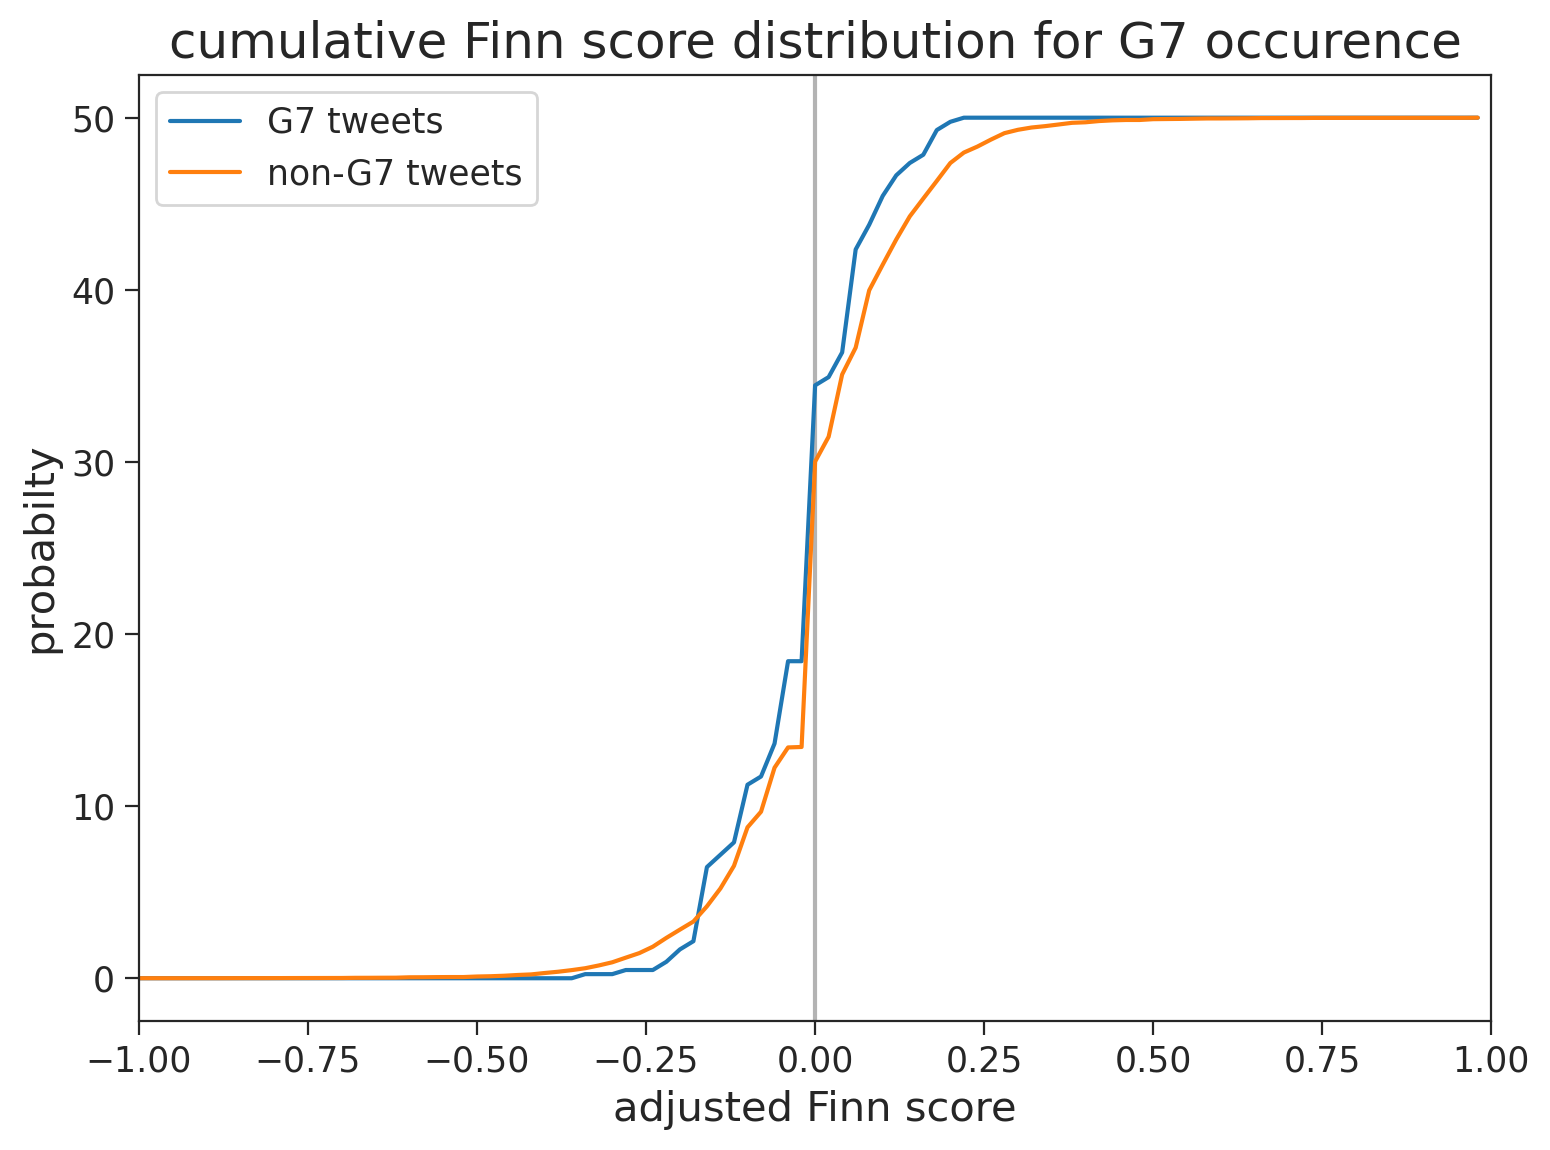

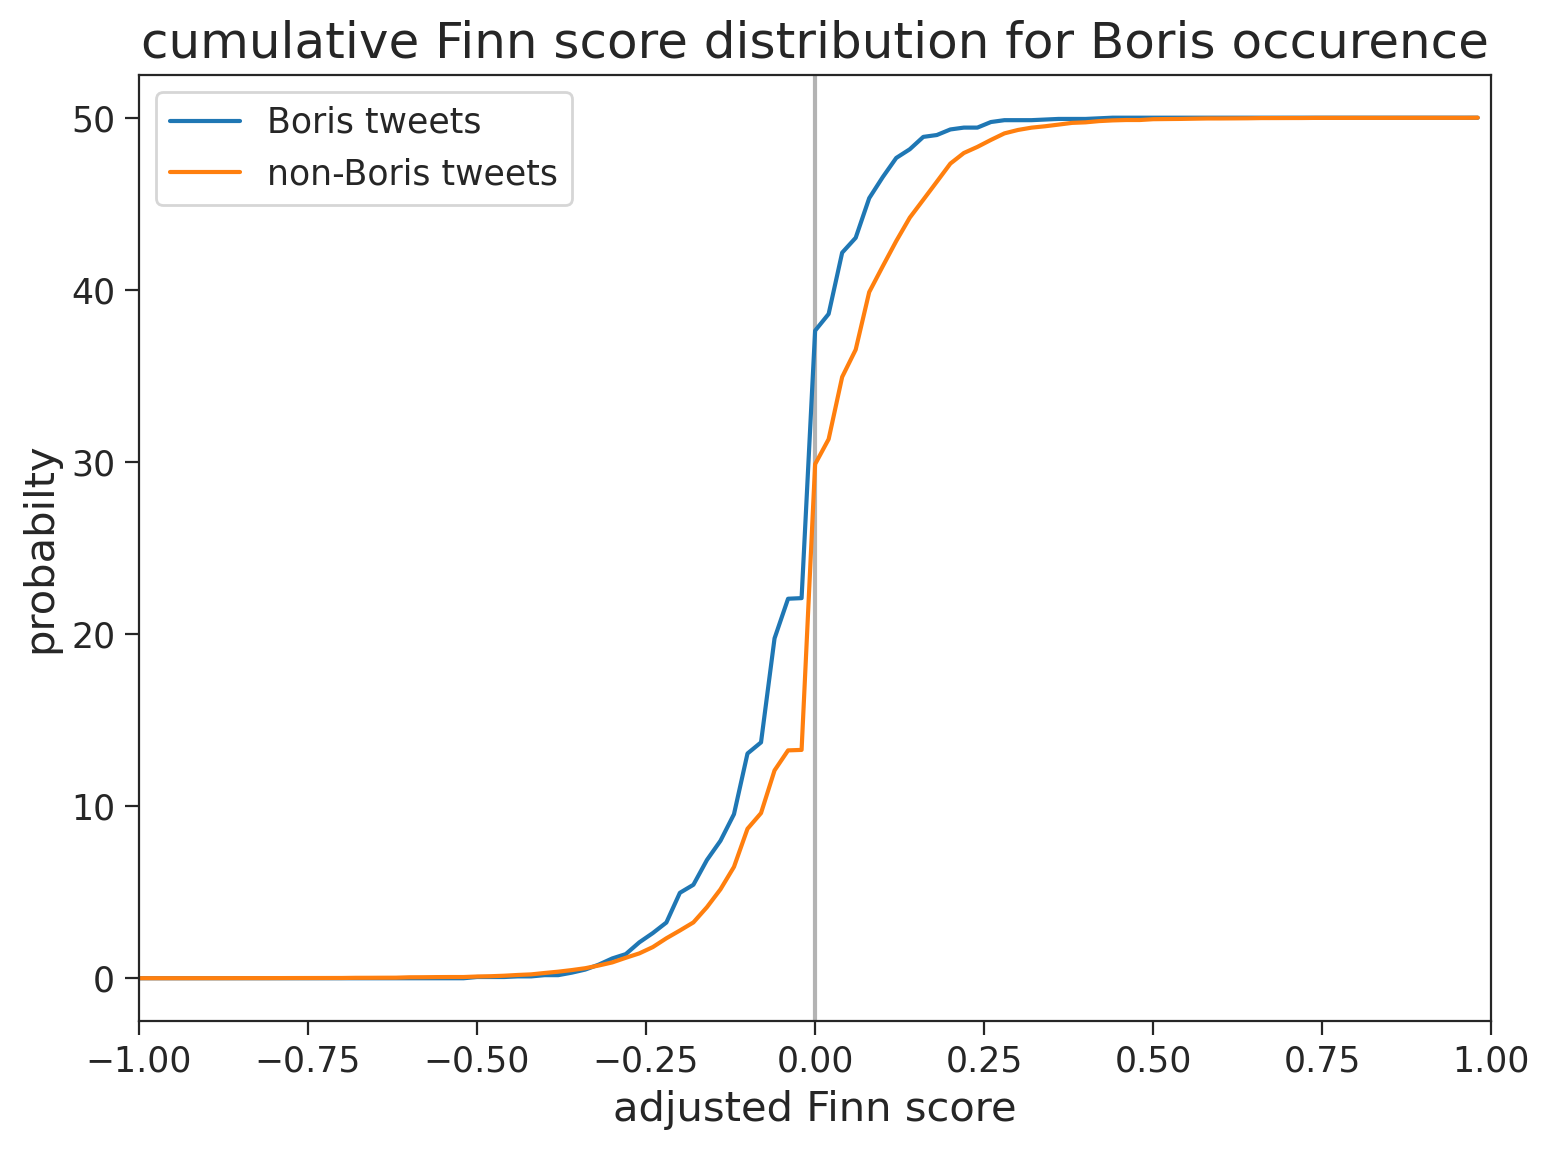

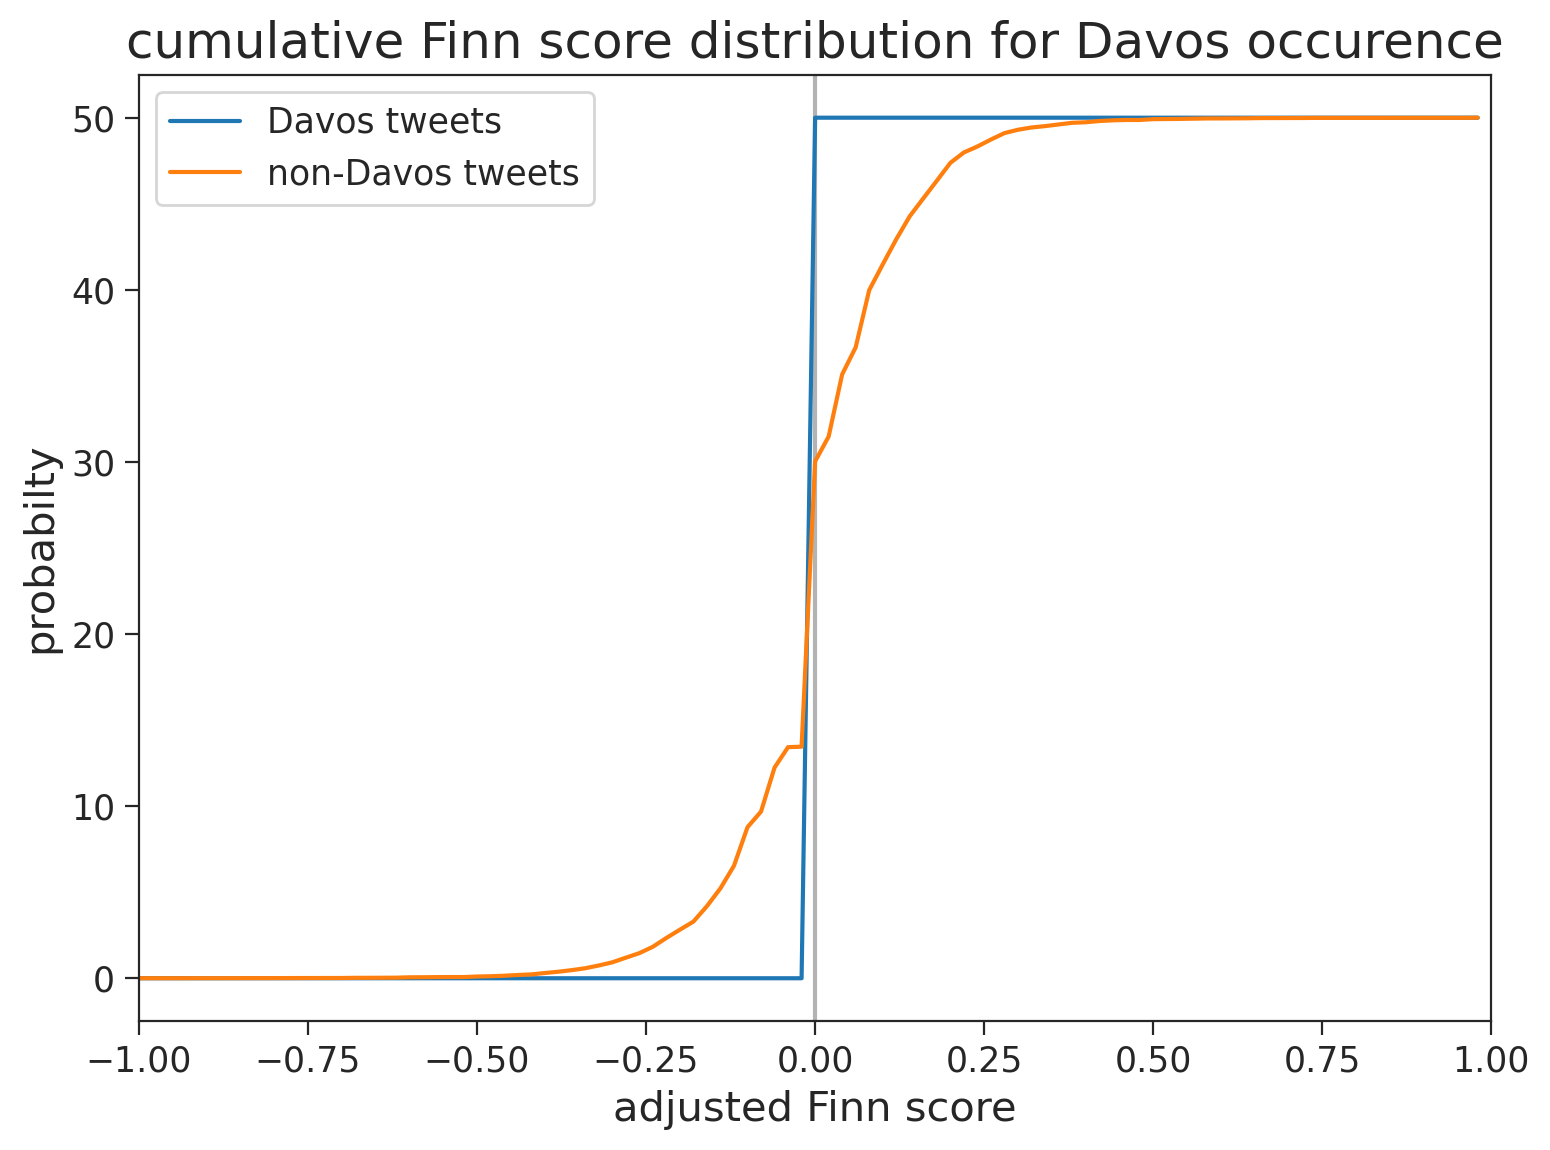

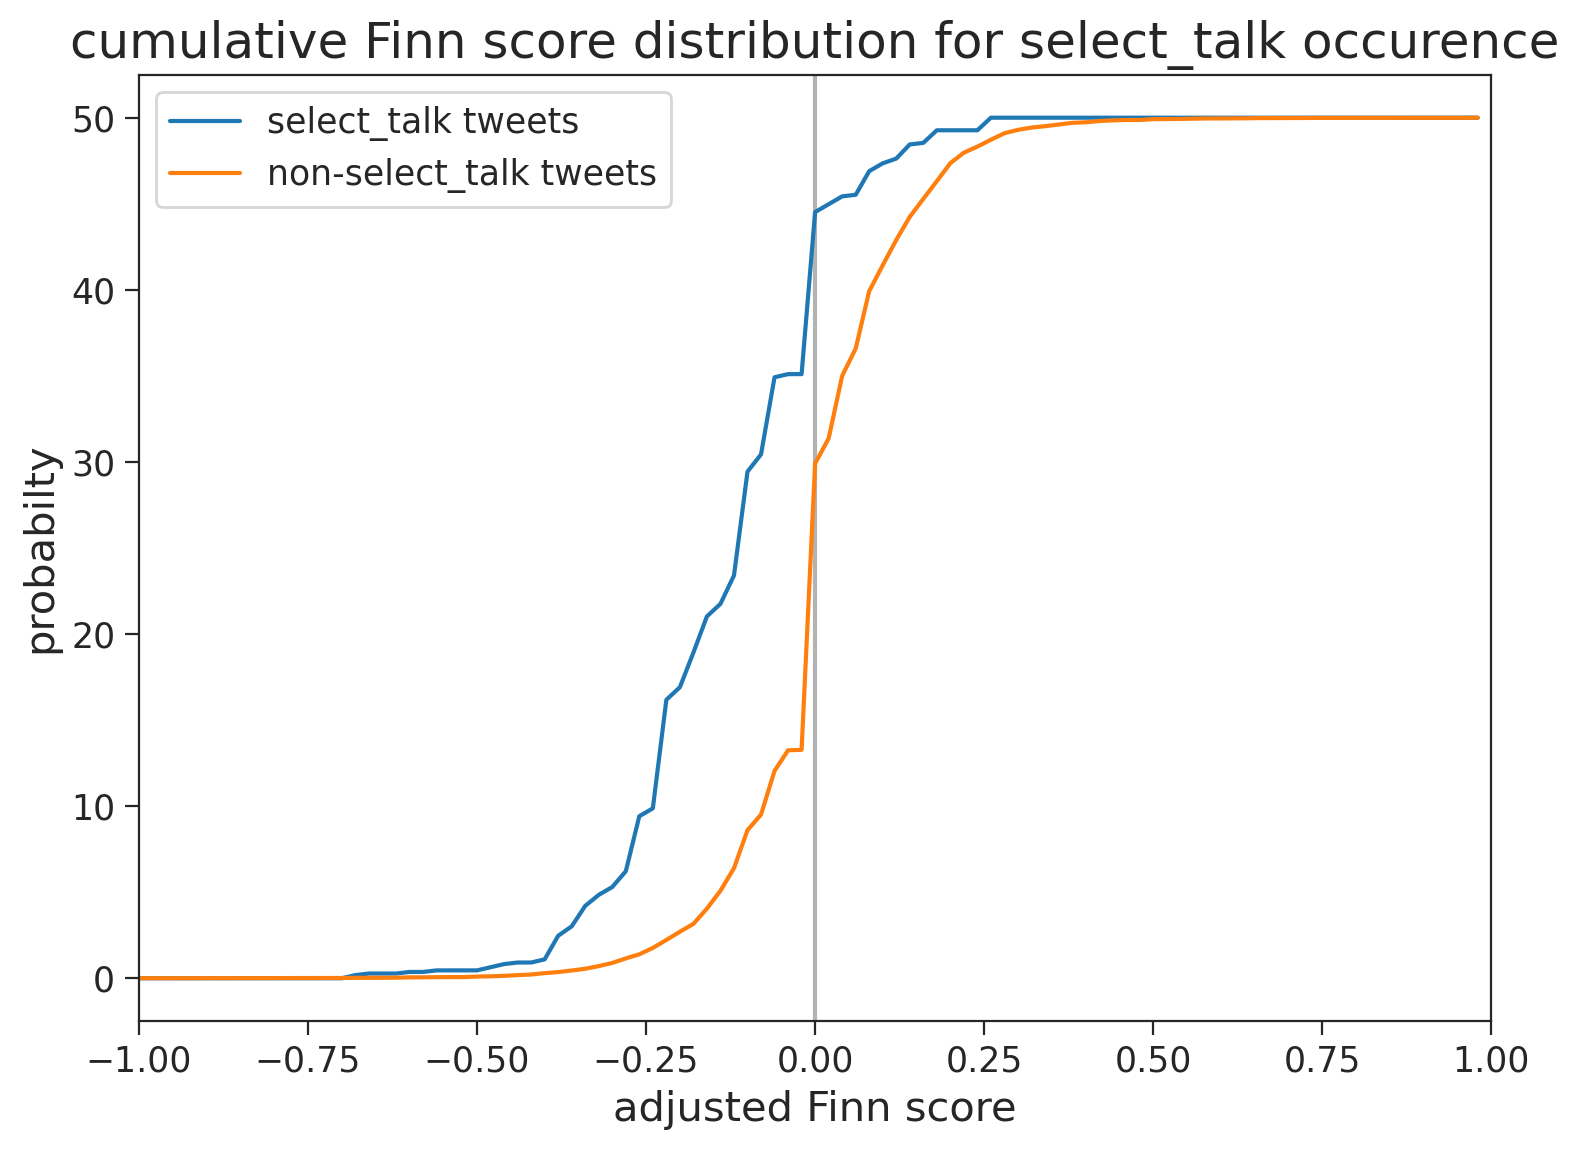

In [45]:
for sel_words in [['Fossil'],['G7'],['Boris'],['Davos'],selected_words]:
    sel_name =sel_words[0] if len(sel_words)==1 else 'select_talk'
    fig,ax=plt.subplots()
    ax.set_xlim(-1,1)
    ax.set_xlabel('adjusted Finn score')
    ax.set_ylabel('probabilty')
    counts,bins=np.histogram(smalldf.loc[smalldf[sel_name],'afinn_adjusted'],bins=np.linspace(-1,1,101),density=True)
    ax.plot(bins[:-1],np.cumsum(counts),color='C0',label=sel_name+' tweets')
    counts,bins=np.histogram(smalldf.loc[~smalldf[sel_name],'afinn_adjusted'],bins=np.linspace(-1,1,101),density=True)
    ax.plot(bins[:-1],np.cumsum(counts),color='C1',label='non-'+sel_name+' tweets')
    ax.axvline(0,color=[0.7]*3,zorder=1)
    ax.legend()
    ax.set_title('cumulative Finn score distribution for '+sel_name+ ' occurence')

Recall from our previous calculations that the tweets containing the selected *hypocrisy*-associated words have minimum adjusted score of -1.5. This score is much more negative than the scores of all four reference words we just plotted. So what is the content of these selected tweets that is causing them to be so negative? The explore this, we can use word clouds to assess the usage of specific words.

# **Section 5: Word Clouds**

To analyze word usage, let's first vectorize the text data. Vectorization (also known as tokenization) here means giving each word in the vocabulary an index and transforming each word sequence to its vector representation and creating a sequence of elements with the corresponding word indices (e.g. the response `['I','love','icecream']` maps to something like `[34823,5937,79345]`). 

We'll use and compare two methods: term-frequency ($\mathrm{tf}$) and term-frequency inverse document frequency ($\mathrm{Tfidf}$). Both of these methods measure how important a term is within a document relative to a collection of documents by using vectorization to transform words into numbers.

**Term Frequency** ($\mathrm{tf}$): the number of times the word appears in a document compared to the total number of words in the document.

$$\mathrm{tf}=\frac{\mathrm{number \; of \; times \; the \; term \; appears \; in \; the \; document}}{\mathrm{total \; number \; of \; terms \; in \; the \; document}}$$

**Inverse Document Frequency** ($\mathrm{idf}$): reflects the proportion of documents in the collection of documents that contain the term. Words unique to a small percentage of documents (e.g., technical jargon terms) receive higher importance values than words common across all documents (e.g., a, the, and).

$$\mathrm{idf}=\frac{\log(\mathrm{number \; of \; the \; documents \; in \; the \; collection})}{\log(\mathrm{number \; of \; documents \; in \; the \; collection \; containing \; the \; term})}$$

Thus the overall term-frequency inverse document frequency can be calculated by multiplying the term-frequency and the inverse document frequency:

$$\mathrm{Tfidf}=\mathrm{Tf} * \mathrm{idf}$$

$\mathrm{Tfidf}$ aims to add more discriminability to frequency as a word relevance metric by downweighting words that appear in many documents since these common words are less discriminative. In other words, the importance of a term is high when it occurs a lot in a given document and rarely in others.

If you are interested in learning more about the mathematical equations used to develop these two methods, please refer to the additional details in the "Further Reading" section for this day.

Let's run both of these methods and store the vectorized data in a dictionary:

In [46]:
vectypes=['counts','Tfidf']
def vectorize(doc_data,ngram_range=(1,1),remove_words=[],min_doc_freq=1):

    vectorized_data_dict={}
    for vectorizer_type in vectypes:
        if vectorizer_type=='counts':
            vectorizer = CountVectorizer(stop_words=remove_words,min_df=min_doc_freq,ngram_range=ngram_range)
        elif vectorizer_type=='Tfidf':
            vectorizer = TfidfVectorizer(stop_words=remove_words,min_df=min_doc_freq,ngram_range=ngram_range)

        vectorized_doc_list = vectorizer.fit_transform(data).todense().tolist()
        feature_names = vectorizer.get_feature_names_out() # or  get_feature_names() depending on scikit learn version
        print('vocabulary size:'+str(len(feature_names)))
        wdf = pd.DataFrame(vectorized_doc_list, columns=feature_names)
        vectorized_data_dict[vectorizer_type]=wdf
    return vectorized_data_dict,feature_names

def plot_wordcloud_and_freqdist(wdf,title_str,feature_names):
    '''
    Plots a word cloud
    '''
    pixel_size=600
    x,y =np.ogrid[:pixel_size,:pixel_size]
    mask = (x -pixel_size/2)**2+(y-pixel_size/2)**2>(pixel_size/2-20)**2
    mask=255*mask.astype(int)
    wc=WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", mask=mask, max_words=50)#,relative_scaling=1)
    wordfreqs=wdf.T.sum(axis=1)
    num_show=50
    sorted_ids=np.argsort(wordfreqs)[::-1]

    fig,ax=plt.subplots(figsize=(10,5))
    ax.bar(x=range(num_show),height=wordfreqs[sorted_ids][:num_show])
    ax.set_xticks(range(num_show))
    ax.set_xticklabels(feature_names[sorted_ids][:num_show],rotation=45,fontsize=8,ha='right');
    ax.set_ylabel('total frequency')
    ax.set_title(title_str+' vectorizer')
    ax.set_ylim(0,10*wordfreqs[sorted_ids][int(num_show/2)])

    ax_wc = inset_axes(ax,width='90%',height='90%')
    wc.generate_from_frequencies(wordfreqs)
    ax_wc.imshow(wc,interpolation='bilinear')
    ax_wc.axis('off')

nltk.download('stopwords') #downloads basic stop words, i.e. words with little semantic value  (e.g. "the"), to be used as words to be removed
remove_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We can now vectorize and look at the wordclouds for single word statistics. Let's explicitly exclude some words and implicity exclude ones that appear in fewer than some threshold number of tweets.

In [47]:
data=selected_tweets['text'].sample(frac=0.1).values #reduce size since the vectorization computation transforms the corpus into an array of large size (vocabulary size x number of tweets)
#let's add some more words that we don't want to track (you can generate this kind of list iteratively by looking at the results and adding to this list):
remove_words += ['cop26','http','https','30','000','je','rt','climate','limacop20','un_climatetalks','climatechange','via','ht','talks','unfccc','peru','peruvian','lima','co']
print(str(len(data))+" tweets")
min_doc_freq=5/len(data)

5747 tweets


vocabulary size:1723
vocabulary size:1723


/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


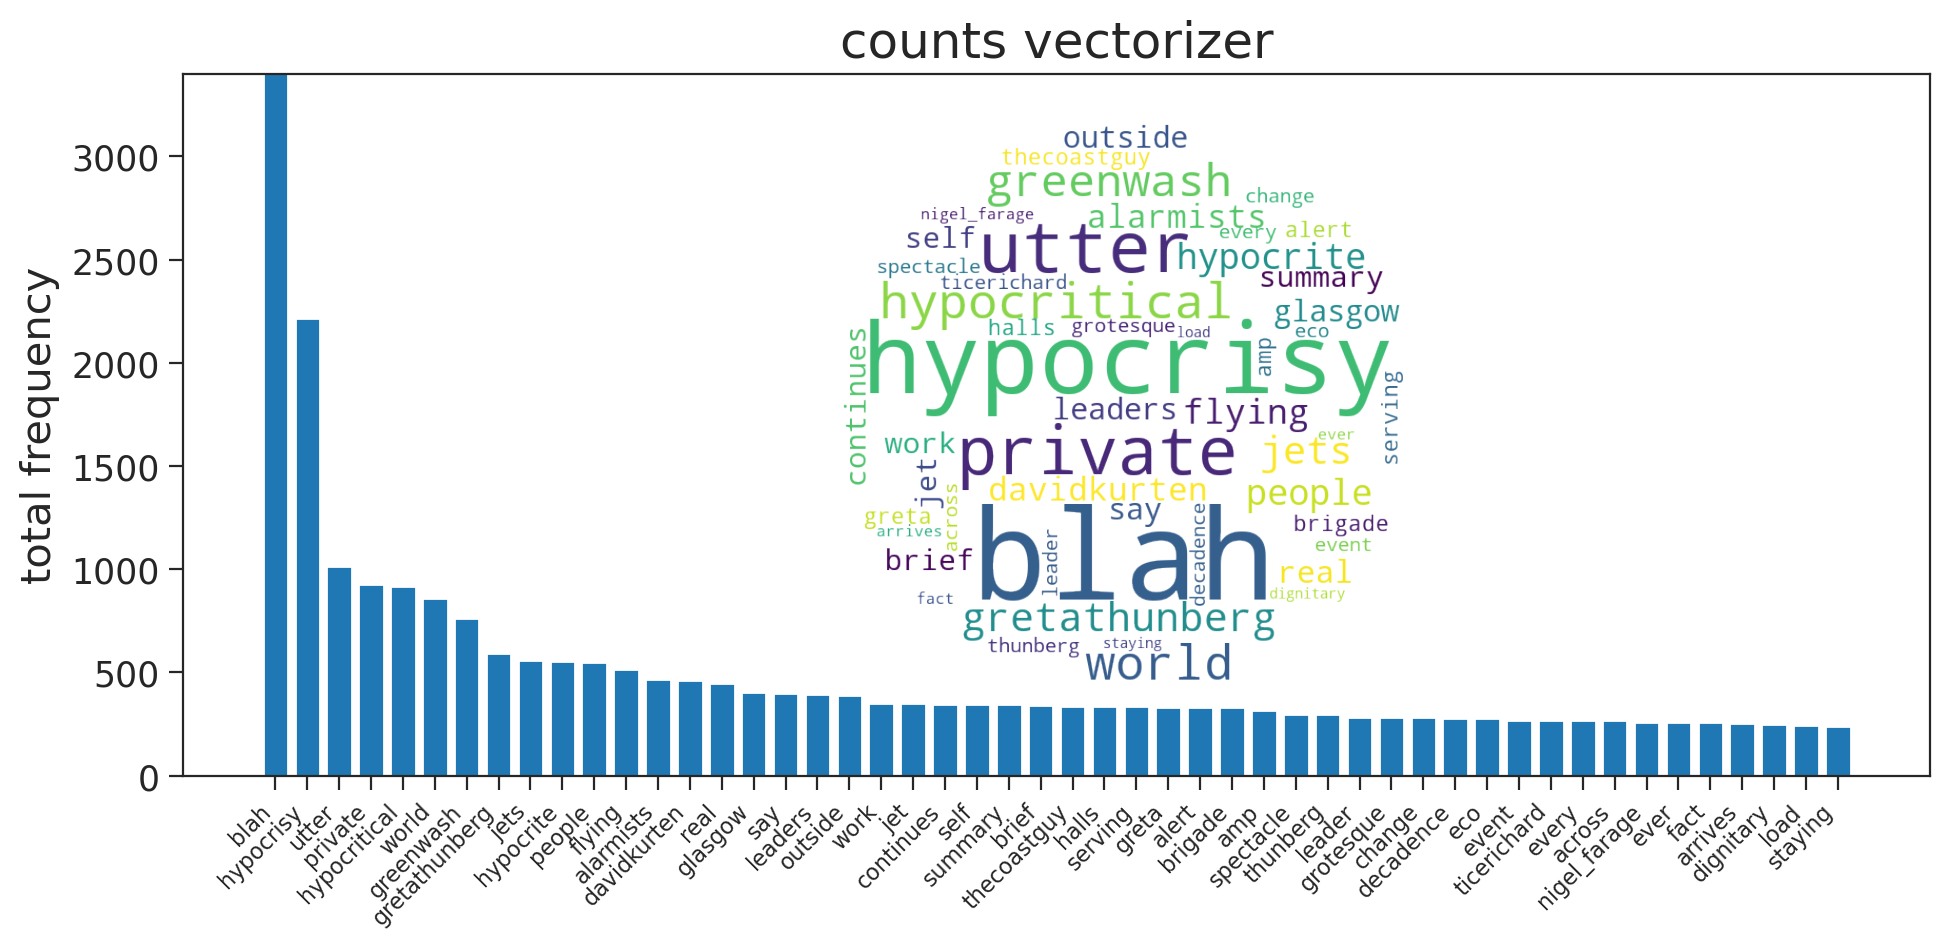

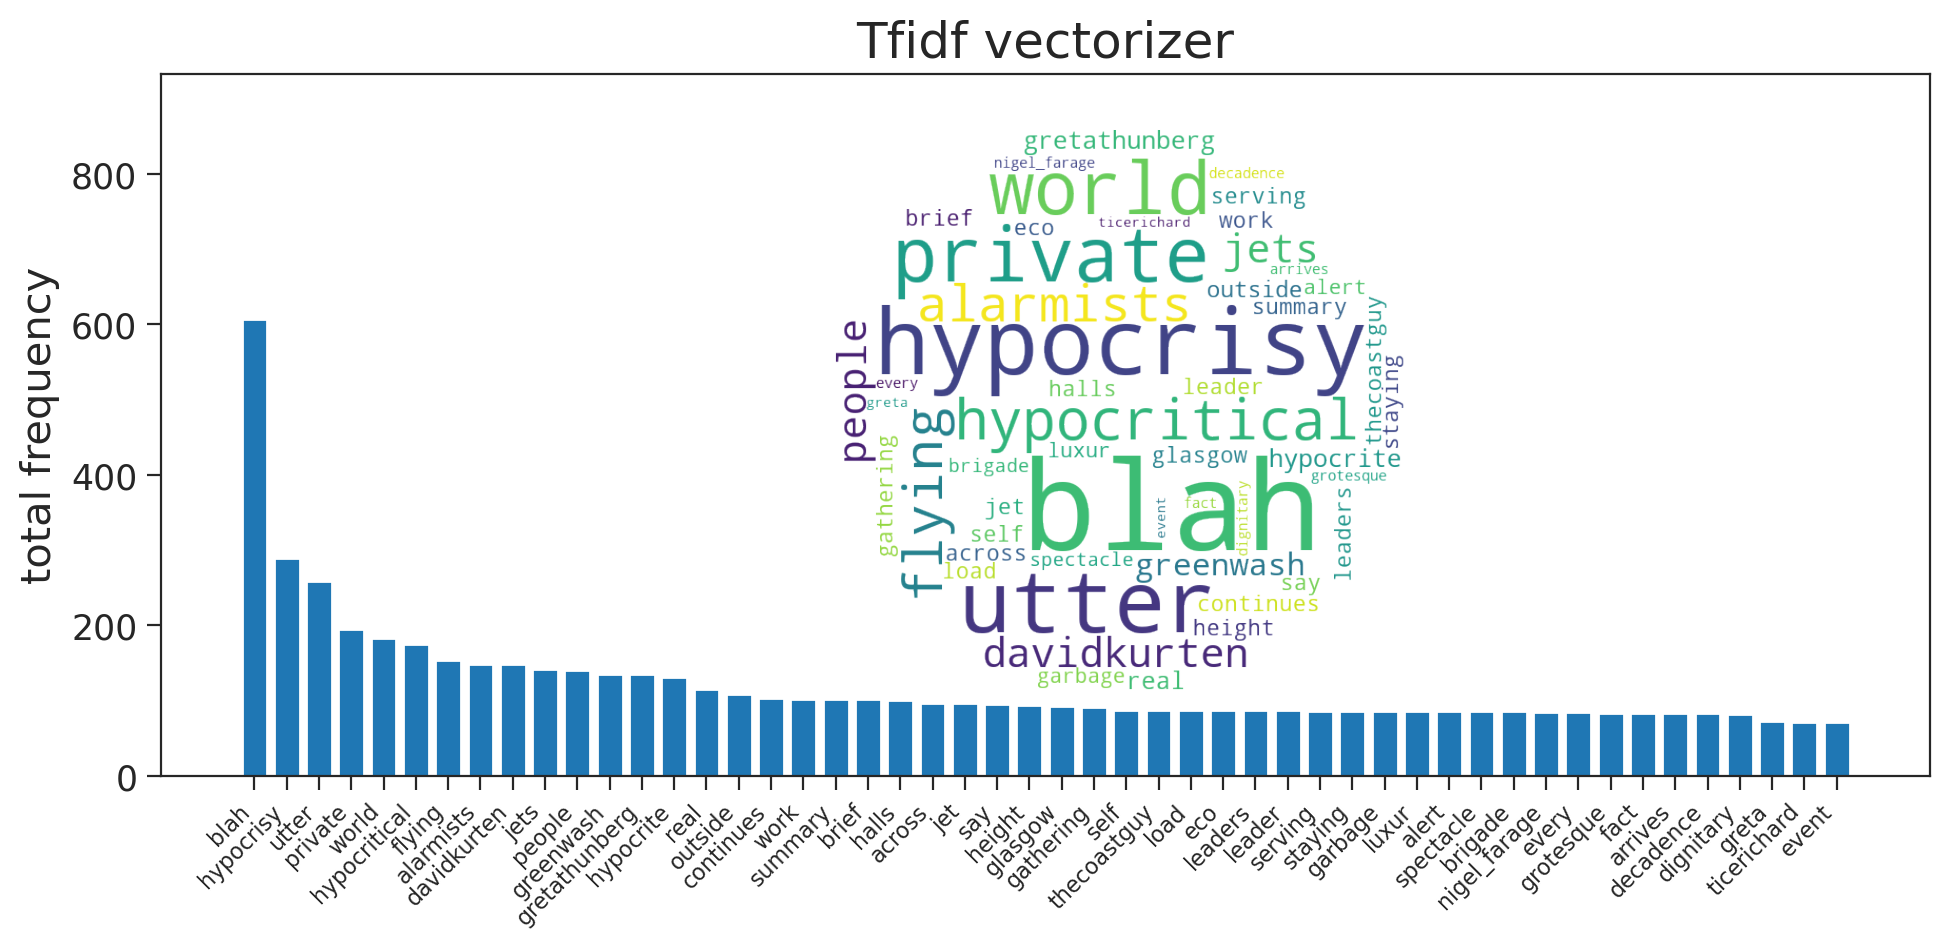

In [48]:
ngram_range=(1,1) #start and end number of words
vectorized_data_dict,feature_names=vectorize(selected_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

Note in the histograms how the $\mathrm{Tfidf}$ vectorizer has scaled down the hypocrisy words such that they are less prevalent relative to the count vectorizer. 

There are some words here  (e.g. `private` and `jet`) that look like they likely would appear in pairs. Let's tell the vectorizer to also look for high frequency *pairs* of words.

vocabulary size:3440
vocabulary size:3440


/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


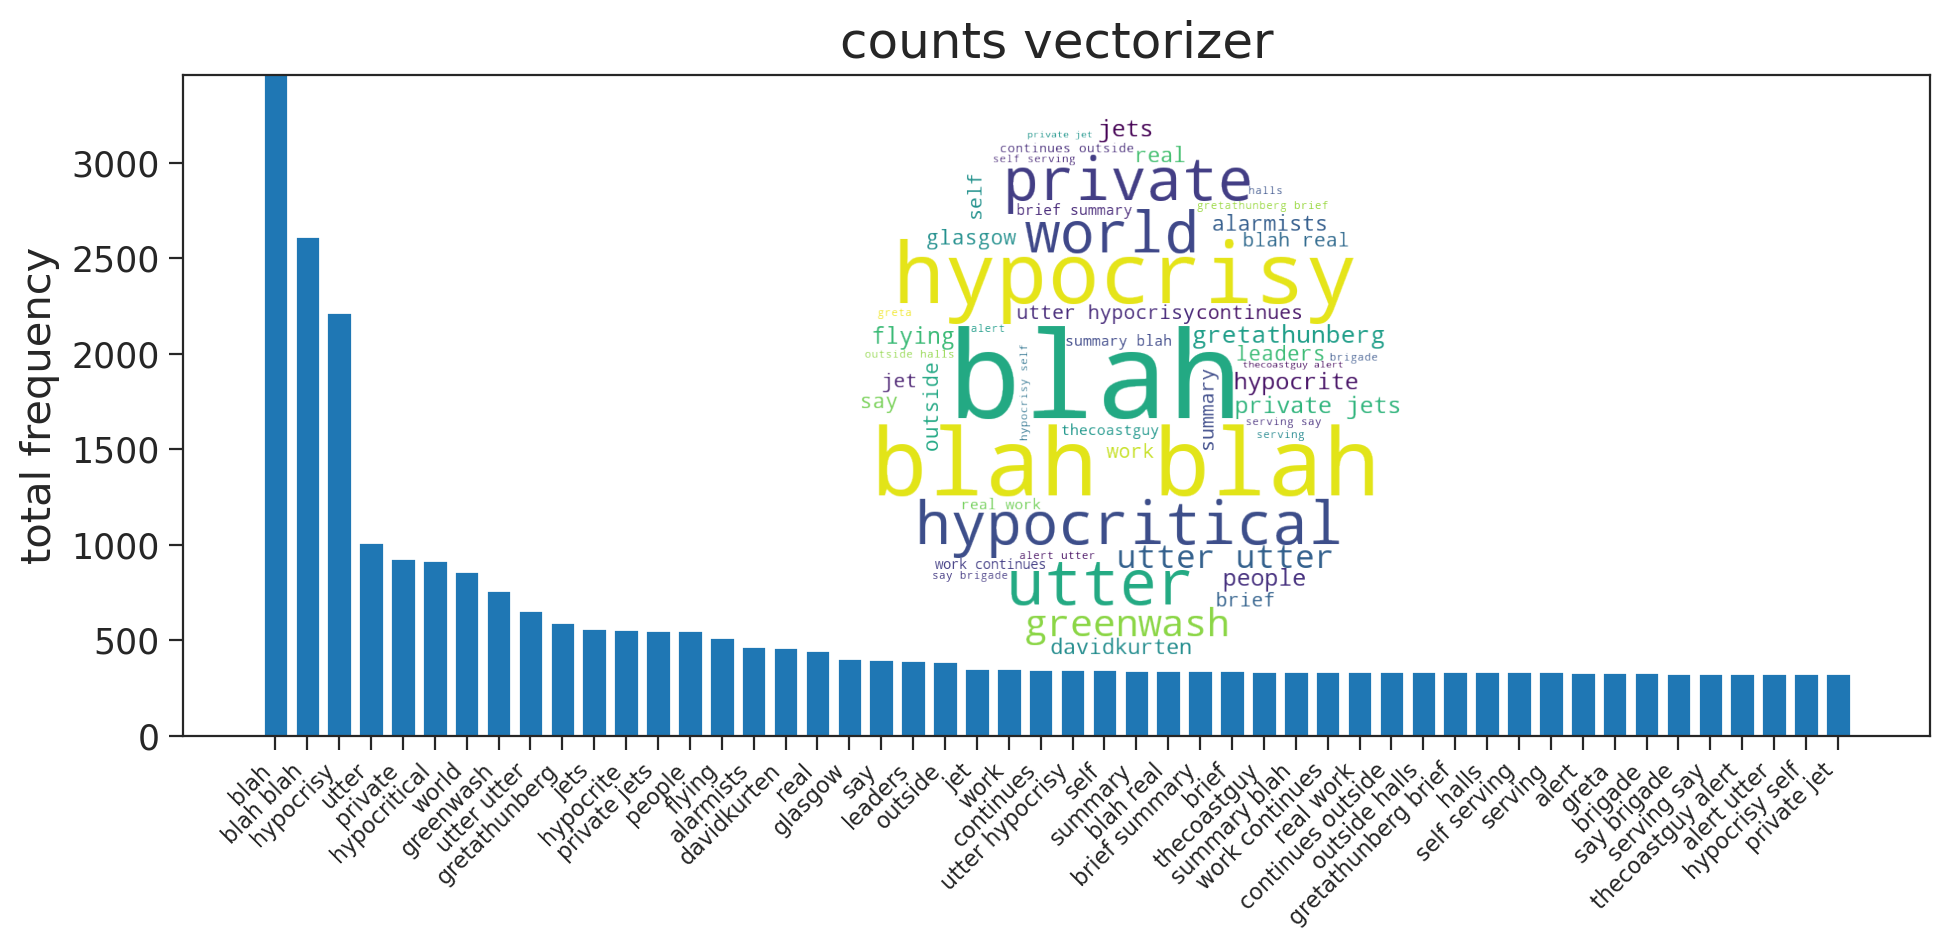

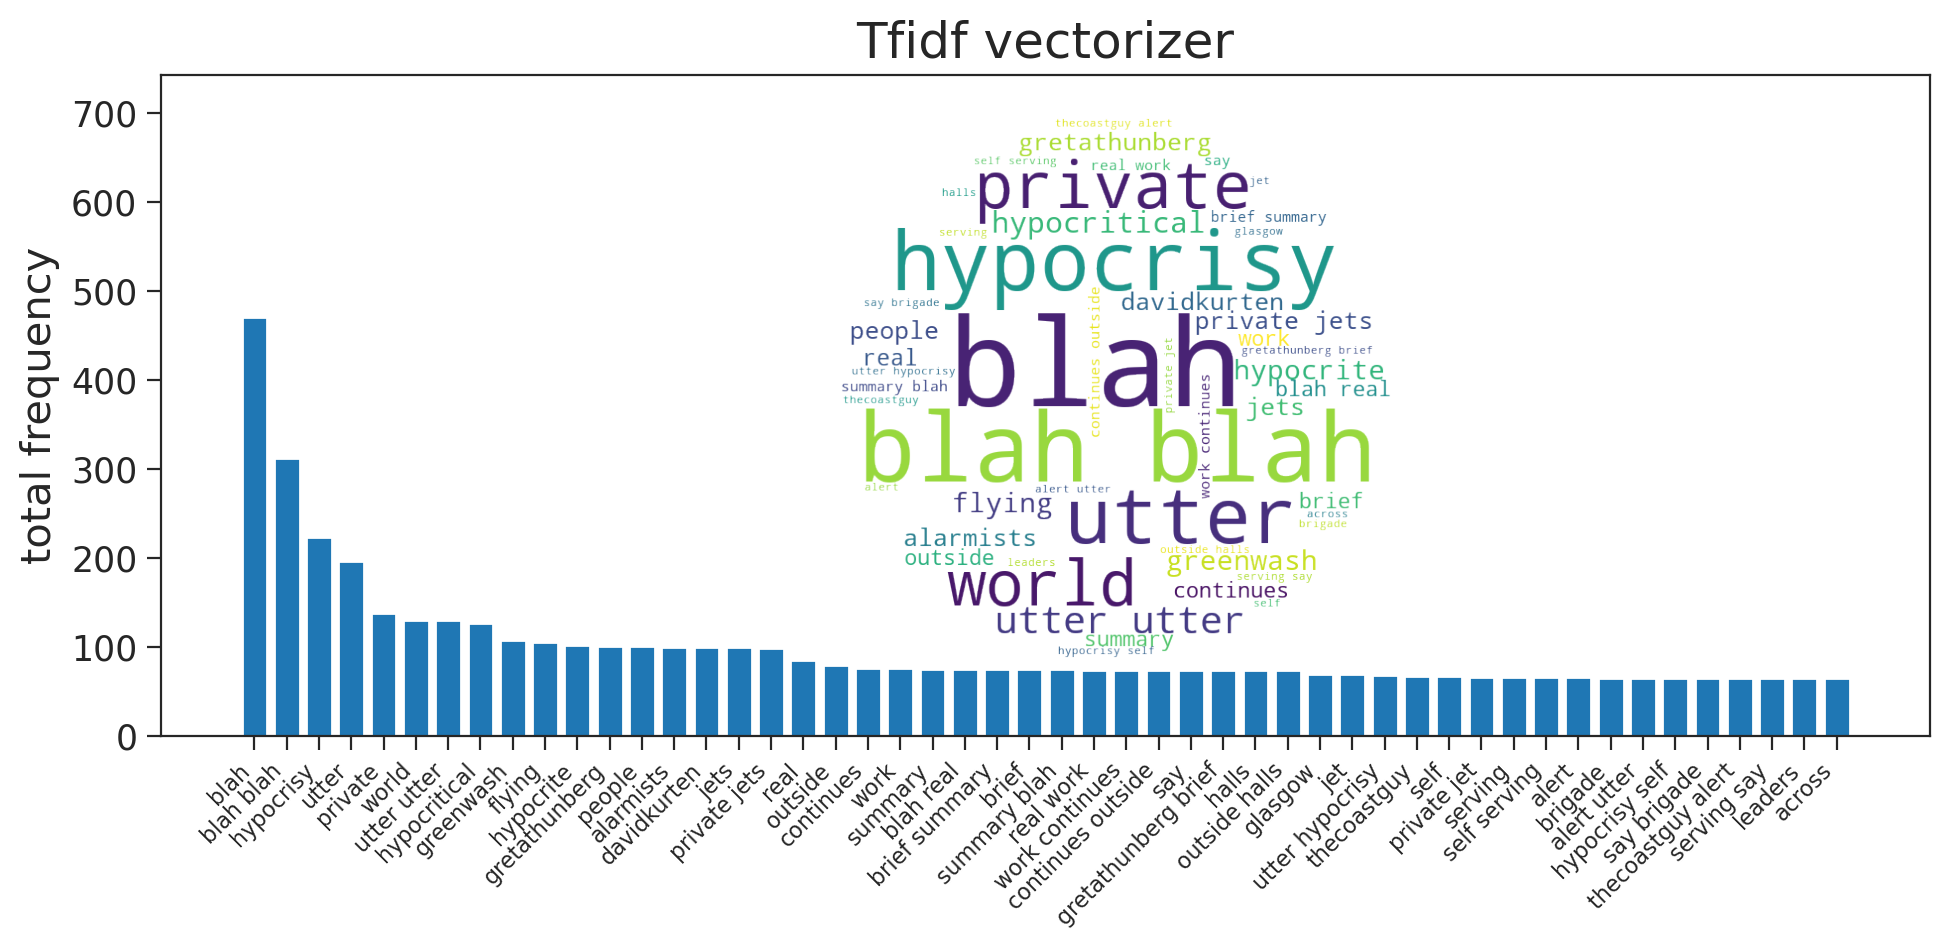

In [49]:
ngram_range= (1,2)#start and end number of words
vectorized_data_dict,feature_names=vectorize(selected_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

The hypocrisy words take up so much frequency that it is hard to see what the remaining words are. To clear this list a bit more, let's also remove the hypocrisy words altogether.

In [50]:
remove_words += selected_words

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'wash'] not in stop_words.
  warnings.warn(


vocabulary size:3235


/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'wash'] not in stop_words.
  warnings.warn(


vocabulary size:3235


/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


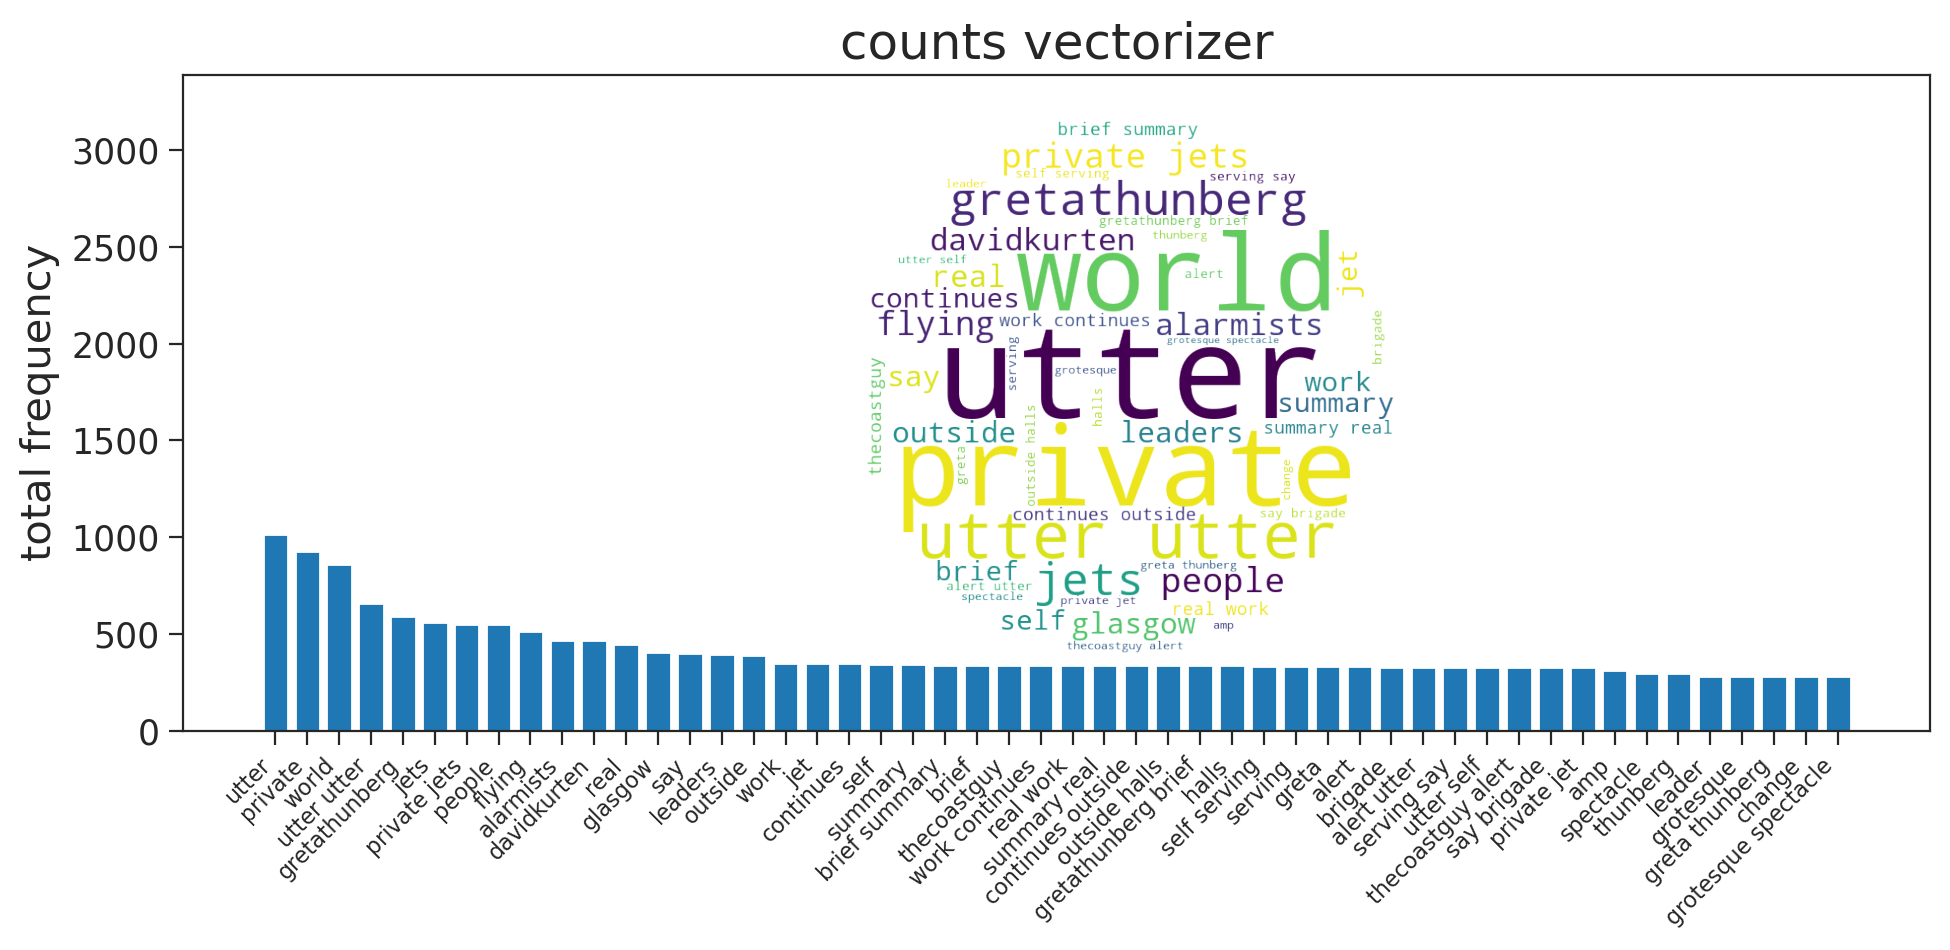

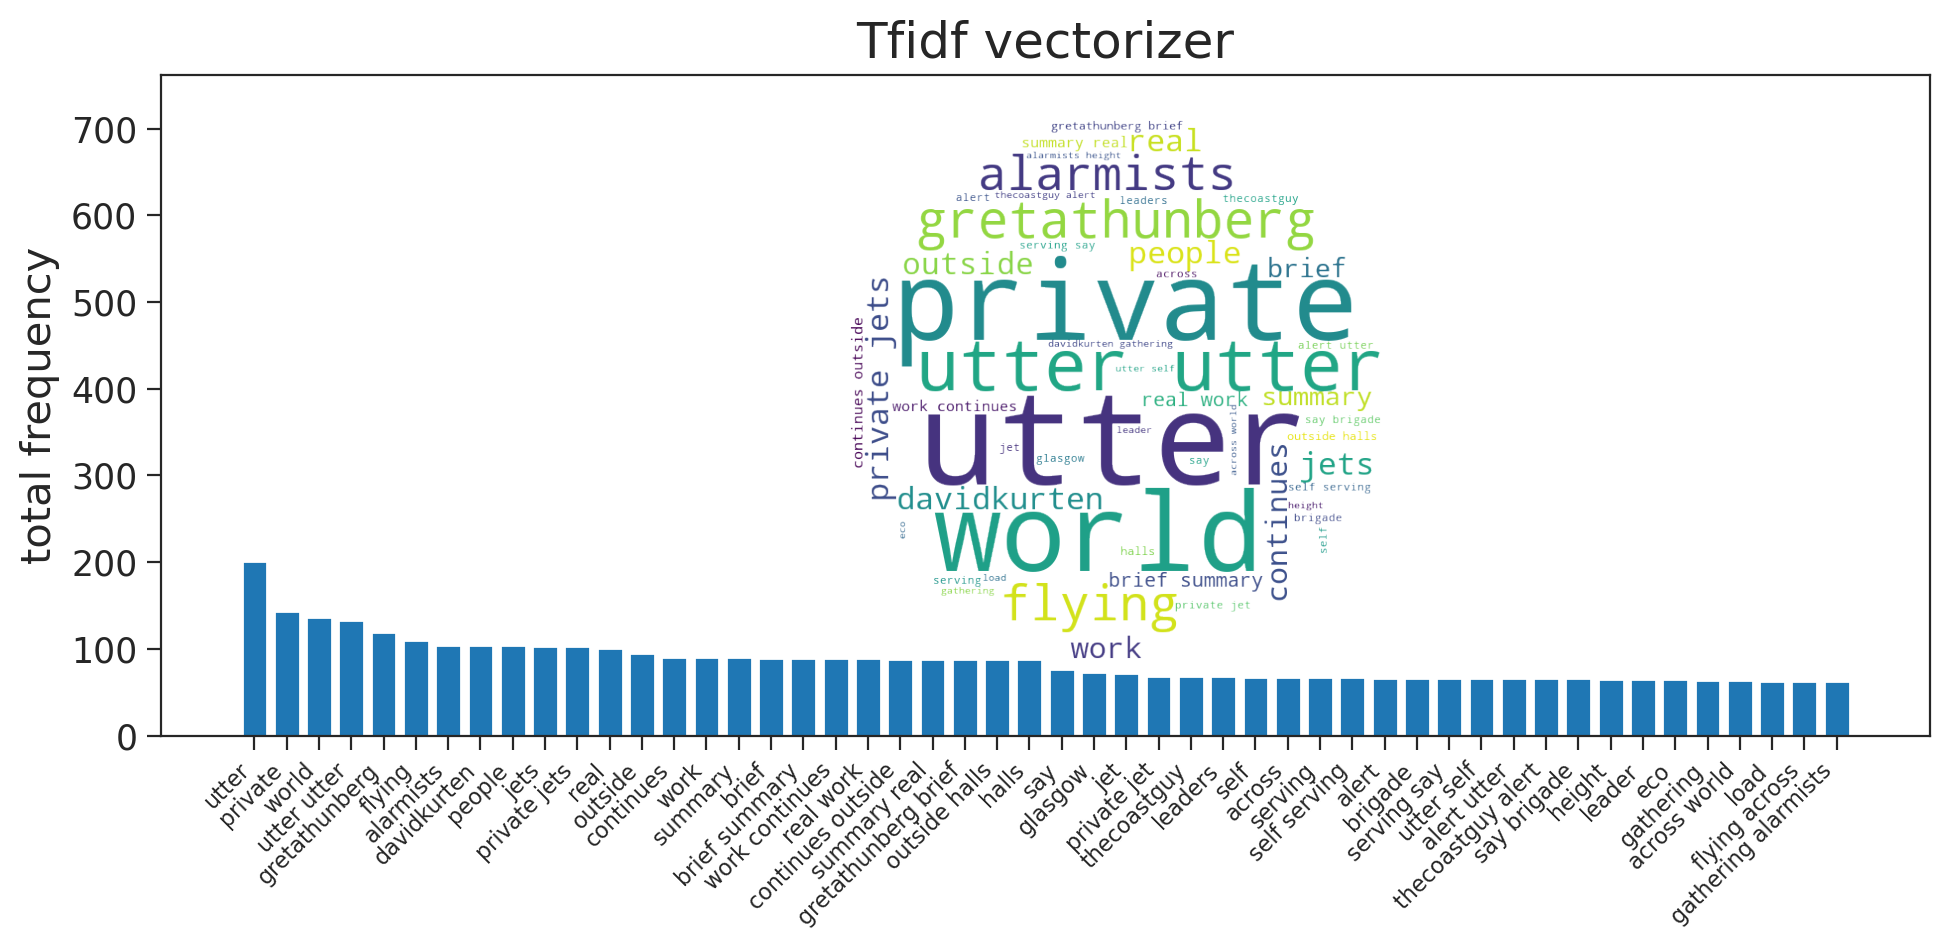

In [51]:
ngram_range= (1,2)#start and end number of words
vectorized_data_dict,feature_names=vectorize(selected_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

Observe that terms we might have expected are associated with hypocrisy, e.g. "flying" are still present. Even when allowing for pairs, the semantics are hard to extract from this analysis that ignores the correlations in usage among multiple words. 

To futher assess statistics, one approach is use a generative model with latent structure.

Topic models (the [structural topic model](https://www.structuraltopicmodel.com/) in particular) are a nice modelling framework to start analyzing those correlations.

For a modern introduction to text analysis in the social sciences, I recommend the textbook:

    Text as Data: A New Framework for Machine Learning and the Social Sciences (2022) by Justin Grimmer, Margaret E. Roberts, and Brandon M. Stewart

# **Summary**
In this tutorial, you've learned how to analyze large amounts of text data from social media to understand public sentiment about climate change. You've been introduced to the process of loading and examining Twitter data, specifically relating to the COP climate change conferences. You've also gained insights into identifying and analyzing sentiments associated with specific words, with a focus on those indicating 'hypocrisy'.

We used techniques to normalize sentiment scores and to compare sentiment among different categories of tweets. You have also learned about text vectorization methods, term-frequency (tf) and term-frequency inverse document frequency (tfidf), and their applications in word usage analysis. This tutorial provided you a valuable stepping stone to further delve into text analysis, which could help deeper our understanding of public sentiment on climate change. Such analysis helps us track how global perceptions and narratives about climate change evolve over time, which is crucial for policy planning and climate communication strategies.

This tutorial therefore not only provided you with valuable tools for text analysis but also demonstrated their potential in contributing to our understanding of climate change perceptions, a key factor in driving climate action.

# **Resources**

The data for this tutorial can be accessed from [Falkenberg et al. *Nature Clim. Chg.* 2022](https://www.nature.com/articles/s41558-022-01527-x). 